<h1>Custom feature extractor for age and gender models </h1>

<p>Import libraries and combining all the fold data into one table</p>

In [1]:
import os
import keras.utils
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb


#data path and setting up data
data = r"C:\Users\keane\PycharmProjects\pythonProject\fyp\Adience\fold"
data_list = []
txt_files = os.listdir(data)

for files in txt_files:
    count = int(files.split("_")[1])
    new = os.path.join(data, files)
    data_list.append(pd.read_table(new))

full_data = pd.concat(data_list, ignore_index=True)
print(full_data.shape)
print(full_data.head())

(19370, 12)
        user_id                original_image  face_id       age gender     x  \
0  30601258@N03  10399646885_67c7d20df9_o.jpg        1  (25, 32)      f     0   
1  30601258@N03  10424815813_e94629b1ec_o.jpg        2  (25, 32)      m   301   
2  30601258@N03  10437979845_5985be4b26_o.jpg        1  (25, 32)      f  2395   
3  30601258@N03  10437979845_5985be4b26_o.jpg        3  (25, 32)      m   752   
4  30601258@N03  11816644924_075c3d8d59_o.jpg        2  (25, 32)      m   175   

      y    dx    dy  tilt_ang  fiducial_yaw_angle  fiducial_score  
0   414  1086  1383      -115                  30              17  
1   105   640   641         0                   0              94  
2   876   771   771       175                 -30              74  
3  1255   484   485       180                   0              47  
4    80   769   768       -75                   0              34  


In [2]:
data = r"C:\Users\keane\PycharmProjects\pythonProject\fyp\UTKFace"
age = []
gender = []
img_path = []

for files in os.listdir(data):
    age.append(files.split("_")[0])
    gender.append(files.split("_")[1])
    img_path.append(os.path.join(data, files))

full = {"age": age, "gender": gender, "img_path": img_path}

df_utk_face = pd.DataFrame(data=full)
df_utk_face

,age,gender,img_path
0,100,0,C:\Users\keane\PycharmProjects\pythonProject\f...
1,100,0,C:\Users\keane\PycharmProjects\pythonProject\f...
2,100,1,C:\Users\keane\PycharmProjects\pythonProject\f...
3,100,1,C:\Users\keane\PycharmProjects\pythonProject\f...
4,100,1,C:\Users\keane\PycharmProjects\pythonProject\f...
...,...,...,...
23703,9,1,C:\Users\keane\PycharmProjects\pythonProject\f...
23704,9,1,C:\Users\keane\PycharmProjects\pythonProject\f...
23705,9,1,C:\Users\keane\PycharmProjects\pythonProject\f...
23706,9,1,C:\Users\keane\PycharmProjects\pythonProject\f...


<p>Copying the age, gender and add it to the a new table with the file paths</p>

In [3]:
df = full_data[['age', 'gender']].copy()

img_path = []
for row in full_data.iterrows():
    path = r"C:/Users/keane/PycharmProjects/pythonProject/fyp/Adience/data/faces/" + row[1].user_id + "/coarse_tilt_aligned_face."+ str(row[1].face_id)+"."+ row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

print(df.age.unique())
print(df.gender.unique())

['(25, 32)' '(38, 43)' '(4, 6)' '(60, 100)' '(15, 20)' '(48, 53)'
 '(8, 12)' '(0, 2)' 'None' '(38, 48)' '35' '3' '55' '58' '22' '13' '45'
 '36' '23' '(38, 42)' '(8, 23)' '(27, 32)' '57' '56' '2' '29' '34' '42'
 '46' '32']
['f' 'm' nan 'u']


In [4]:
print(df_utk_face.age.unique())
print(df_utk_face.gender.unique())

['100' '101' '103' '105' '10' '110' '111' '115' '116' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '1' '20' '21' '22' '23' '24' '25' '26' '27' '28'
 '29' '2' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '3' '40' '41'
 '42' '43' '44' '45' '46' '47' '48' '49' '4' '50' '51' '52' '53' '54' '55'
 '56' '57' '58' '59' '5' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69'
 '6' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79' '7' '80' '81' '82'
 '83' '84' '85' '86' '87' '88' '89' '8' '90' '91' '92' '93' '95' '96' '99'
 '9']
['0' '1']


<p>Cleaning all the none/NAN data from the table and removing u data from gender</p>

In [5]:
age_map_utk = [('1', '0-2'), ('2', '0-2'), ('3', '0-2'), ('4', '4-6'), ('5', '4-6'), ('6', '4-6'), ('7', '4-6'), ('8', '8-13'), ('9', '8-13'), ('10', '8-13'), ('11', '8-13'), ('12', '8-13'), ('13', '8-13'), ('14', '8-13'), ('15', '15-20'), ('16', '15-20'), ('17', '15-20'), ('18', '15-20'), ('19', '15-20'), ('20', '15-20'), ('21', '15-20'), ('22', '15-20'), ('23', '25-32'), ('24', '25-32'), ('25', '25-32'), ('26', '25-32'), ('27', '25-32'), ('28', '25-32'), ('29', '25-32'), ('30', '25-32'), ('31', '25-32'), ('32', '25-32'), ('33', '25-32'), ('34', '25-32'), ('35', '38-43'), ('36', '38-43'), ('37', '38-43'), ('38', '38-43'), ('39', '38-43'), ('40', '38-43'), ('41', '38-43'), ('42', '38-43'), ('43', '38-43'), ('44', '38-43'), ('45', '38-43'),  ('46', '48-53'),  ('47', '48-53'),  ('48', '48-53'),  ('49', '48-53'),  ('50', '48-53'),  ('51', '48-53'),  ('52', '48-53'), ('53', '48-53'),  ('54', '48-53'),  ('55', '48-53'),  ('56', '48-53'), ('57', '60+'), ('58', '60+'), ('59', '60+'), ('60', '60+'), ('61', '60+'), ('62', '60+'), ('63', '60+'), ('64', '60+'), ('65', '60+'), ('66', '60+'), ('67', '60+'), ('68', '60+'), ('69', '60+'), ('70', '60+'), ('71', '60+'), ('72', '60+'), ('73', '60+'), ('74', '60+'), ('75', '60+'), ('76', '60+'), ('77', '60+'), ('78', '60+'), ('79', '60+'), ('80', '60+'), ('81', '60+'), ('82', '60+'), ('83', '60+'), ('84', '60+'), ('85', '60+'), ('86', '60+'), ('87', '60+'), ('88', '60+'), ('89', '60+'), ('90', '60+'), ('90', '60+'), ('91', '60+'), ('92', '60+'), ('93', '60+'), ('95', '60+'), ('96', '60+'), ('99', '60+'), ('100', '60+'), ('101', '60+'), ('103', '60+'), ('105', '60+'), ('110', '60+'), ('111', '60+'), ('115', '60+'), ('116', '60+')]

age_map_utk_dict = {age[0]: age[1] for age in age_map_utk}
delete = []
for index, ages in enumerate(df_utk_face.age):
    if ages == 'None':
        delete.append(index)
    else:
        df_utk_face.age.loc[index] = age_map_utk_dict[ages]
        
df_utk_face = df_utk_face.drop(labels=delete, axis=0)
df_utk_face = df_utk_face.dropna()
clean_utk_data = df_utk_face.copy()
clean_utk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       23708 non-null  object
 1   gender    23708 non-null  object
 2   img_path  23708 non-null  object
dtypes: object(3)
memory usage: 555.8+ KB


In [6]:
age_maps = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '38-43'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]
gender = ['f','m','u']

age_maps_dict = {age[0]: age[1] for age in age_maps}
delete = []
for index, ages in enumerate(df.age):
    if ages == 'None':
        delete.append(index)
    else:
        df.age.loc[index] = age_maps_dict[ages]

df = df.drop(labels=delete, axis=0)
df = df.dropna()

clean_data = df[df.gender != 'u'].copy()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   img_path  17452 non-null  object
dtypes: object(3)
memory usage: 545.4+ KB


<p>Convert the gender and age to labels</p>

In [7]:
age_label = {
    '0-2' : 0,
    '4-6' : 1,
    '8-13' : 2,
    '15-20' : 3,
    '25-32' : 4,
    '38-43' : 5,
    '48-53' : 6,
    '60+' : 7
}
clean_utk_data['age'] = clean_utk_data['age'].apply(lambda age: age_label[age])

In [8]:
clean_utk_data.head()

,age,gender,img_path
0,7,0,C:\Users\keane\PycharmProjects\pythonProject\f...
1,7,0,C:\Users\keane\PycharmProjects\pythonProject\f...
2,7,1,C:\Users\keane\PycharmProjects\pythonProject\f...
3,7,1,C:\Users\keane\PycharmProjects\pythonProject\f...
4,7,1,C:\Users\keane\PycharmProjects\pythonProject\f...


In [9]:
gender_label = {'m' : 0,  'f' : 1}
age_label = {
    '0-2' : 0,
    '4-6' : 1,
    '8-13' : 2,
    '15-20' : 3,
    '25-32' : 4,
    '38-43' : 5,
    '48-53' : 6,
    '60+' : 7
}

clean_data['age'] = clean_data['age'].apply(lambda age: age_label[age])
clean_data['gender'] = clean_data['gender'].apply(lambda  gender: gender_label[gender])

In [10]:
clean_data.head()

,age,gender,img_path
0,4,1,C:/Users/keane/PycharmProjects/pythonProject/f...
1,4,0,C:/Users/keane/PycharmProjects/pythonProject/f...
2,4,1,C:/Users/keane/PycharmProjects/pythonProject/f...
3,4,0,C:/Users/keane/PycharmProjects/pythonProject/f...
4,4,0,C:/Users/keane/PycharmProjects/pythonProject/f...


In [11]:
combined = [clean_data, clean_utk_data]
final_clean = pd.concat(combined)

In [12]:
final_clean

,age,gender,img_path
0,4,1,C:/Users/keane/PycharmProjects/pythonProject/f...
1,4,0,C:/Users/keane/PycharmProjects/pythonProject/f...
2,4,1,C:/Users/keane/PycharmProjects/pythonProject/f...
3,4,0,C:/Users/keane/PycharmProjects/pythonProject/f...
4,4,0,C:/Users/keane/PycharmProjects/pythonProject/f...
...,...,...,...
23703,2,1,C:\Users\keane\PycharmProjects\pythonProject\f...
23704,2,1,C:\Users\keane\PycharmProjects\pythonProject\f...
23705,2,1,C:\Users\keane\PycharmProjects\pythonProject\f...
23706,2,1,C:\Users\keane\PycharmProjects\pythonProject\f...


Some helpful functions to help to plot accuracy, losses and confusion matrix

In [13]:
def plot_loss(loss, val_loss):
    plt.clf()
    epochs = range(1, len(loss) + 1)
    blue_dots = 'bo'
    solid_blue_line = 'b'

    #plot the values
    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')

    #title and label of graphs and axes
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def plot_accuracy(acc, val_acc):
    plt.clf()
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    #plot the values
    plt.plot(epochs, acc, blue_dots, label = 'Training accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation accuracy')

    #title and lavel of graphs and axes
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
gender_labels = ['male', 'female']
age_labels = ['0-2', '4-6', '8-13', '15-20', '25-32', '38-43', '48-53', '60+']


def plot_confusion_matrix(conf_matrix, class_labels):
    plt.figure(figsize=(8, 6))
    sb.set(font_scale=1.2)
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

<p>Splitting and ensuring that the data is in the correct format to be inputted into the training script.</p>

In [14]:
#splitting the data into test and validation as well as a portion to test
x = final_clean[['img_path']]
yg = final_clean[['gender']]
ya = final_clean[['age']]

# split training from test set
train_gx, test_gx, train_gy, test_gy = train_test_split(x, yg, random_state=10, test_size=0.1)
train_ax, test_ax, train_ay, test_ay = train_test_split(x, ya, random_state=10, test_size=0.1)

# split training set into train and val
xg_train, xg_val, yg_train, yg_val = train_test_split(train_gx, train_gy, random_state=10, test_size=0.3)
xa_train, xa_val, ya_train, ya_val = train_test_split(train_ax, train_ay, random_state=10, test_size=0.3)

#remove index from img path, gender and age df
xa_train = xa_train.reset_index()
xa_train = xa_train.drop('index', axis=1)
xa_val = xa_val.reset_index()
xa_val = xa_val.drop('index', axis=1)
test_ax = test_ax.reset_index()
test_ax = test_ax.drop('index', axis=1)

yg_train = yg_train.reset_index()
yg_train = yg_train.drop('index', axis=1)
yg_val = yg_val.reset_index()
yg_val = yg_val.drop('index', axis=1)
test_gy = test_gy.reset_index()
test_gy = test_gy.drop('index', axis=1)

ya_train = ya_train.reset_index()
ya_train = ya_train.drop('index', axis=1)
ya_val = ya_val.reset_index()
ya_val = ya_val.drop('index', axis=1)
test_ay = test_ay.reset_index()
test_ay = test_ay.drop('index', axis=1)
ya_train = keras.utils.to_categorical(ya_train)
ya_val = keras.utils.to_categorical(ya_val)

# Preprocess the image paths and convert them to tensors
def preprocess_image(path):
    img = tf.image.decode_jpeg(tf.io.read_file(path))
    img = tf.image.resize_with_pad(img, target_height=224, target_width=224)
    return img

# Create a dataset for training, validation, and test
batch_size = 32

test_ax_dataset = tf.data.Dataset.from_tensor_slices(test_ax['img_path'].values)
test_ax_dataset = test_ax_dataset.map(preprocess_image).batch(batch_size)

train_age_dataset = tf.data.Dataset.from_tensor_slices((xa_train['img_path'].values, ya_train))
train_age_dataset = train_age_dataset.map(lambda x, y: (preprocess_image(x), y))
train_age_dataset = train_age_dataset.batch(batch_size)

val_age_dataset = tf.data.Dataset.from_tensor_slices((xa_val['img_path'].values, ya_val))
val_age_dataset = val_age_dataset.map(lambda x, y: (preprocess_image(x), y))
val_age_dataset = val_age_dataset.batch(batch_size)

In [15]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

class custom_feature_extractor(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super(custom_feature_extractor, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv1 = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=(224, 224, 3))
        self.maxpool1 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.maxpool3 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))
        self.conv4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.maxpool4 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self, img):
        x = self.conv1(img)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.flatten(x)
        return x
    
    def set_trainable(self, trainable):
        layers_to_train = [self.conv1, self.maxpool1, self.conv2, self.maxpool2, self.conv3, self.maxpool3, self.conv4, self.maxpool4]
        for layer in layers_to_train:
            layer.trainable = trainable

with tf.device('/GPU:0'):
    age_model = tf.keras.Sequential([
        custom_feature_extractor(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])


    gender_model = tf.keras.Sequential([
        custom_feature_extractor(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

input_shape = (None, 224, 224, 3)

age_model.build(input_shape)
gender_model.build(input_shape)
age_model.summary()
gender_model.summary()
age_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gender_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_feature_extractor (c  (None, 18432)            1558656   
 ustom_feature_extractor)                                        
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 3,926,856
Trainable params: 3,926,856
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)           

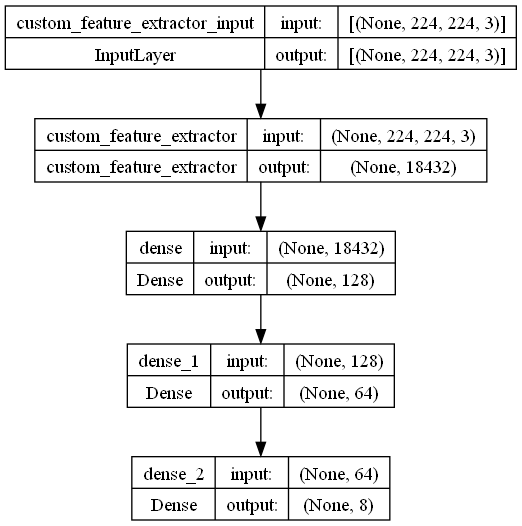

In [15]:
tf.keras.utils.plot_model(age_model, show_shapes=True, show_layer_names=True)

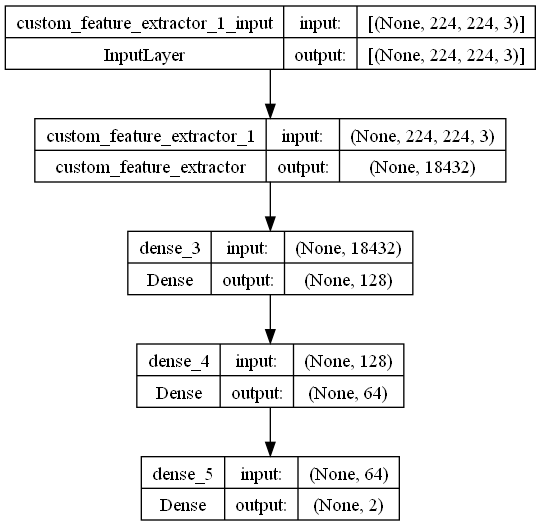

In [16]:
tf.keras.utils.plot_model(gender_model, show_shapes=True, show_layer_names=True)

In [17]:
age_results = age_model.fit(train_age_dataset, validation_data= val_age_dataset ,epochs=10)

Epoch 1/10
811/811 [==============================] - 287s 353ms/step - loss: 2.2655 - accuracy: 0.3724 - val_loss: 1.5223 - val_accuracy: 0.4358
Epoch 2/10
811/811 [==============================] - 284s 350ms/step - loss: 1.4310 - accuracy: 0.4610 - val_loss: 1.3443 - val_accuracy: 0.4849
Epoch 3/10
811/811 [==============================] - 281s 347ms/step - loss: 1.3263 - accuracy: 0.4882 - val_loss: 1.2970 - val_accuracy: 0.5003
Epoch 4/10
811/811 [==============================] - 282s 348ms/step - loss: 1.2554 - accuracy: 0.5135 - val_loss: 1.2458 - val_accuracy: 0.5142
Epoch 5/10
811/811 [==============================] - 302s 373ms/step - loss: 1.2002 - accuracy: 0.5345 - val_loss: 1.2245 - val_accuracy: 0.5178
Epoch 6/10
811/811 [==============================] - 295s 363ms/step - loss: 1.1449 - accuracy: 0.5563 - val_loss: 1.2797 - val_accuracy: 0.5247
Epoch 7/10
811/811 [==============================] - 300s 370ms/step - loss: 1.1105 - accuracy: 0.5669 - val_loss: 1.2133 -

In [16]:
yg_train = np.asarray(yg_train).astype(np.float32)
yg_val = np.asarray(yg_val).astype(np.float32)
train_gender_dataset = tf.data.Dataset.from_tensor_slices((xg_train['img_path'].values, yg_train))
train_gender_dataset = train_gender_dataset.map(lambda x, y: (preprocess_image(x), y))
train_gender_dataset = train_gender_dataset.batch(batch_size)

val_gender_dataset = tf.data.Dataset.from_tensor_slices((xg_val['img_path'].values, yg_val))
val_gender_dataset = val_gender_dataset.map(lambda x, y: (preprocess_image(x), y))
val_gender_dataset = val_gender_dataset.batch(batch_size)

In [62]:
gender_results = gender_model.fit(train_gender_dataset, validation_data=val_gender_dataset ,epochs=10)

Epoch 1/10
811/811 [==============================] - 356s 437ms/step - loss: 0.9322 - accuracy: 0.6916 - val_loss: 0.4672 - val_accuracy: 0.7689
Epoch 2/10
811/811 [==============================] - 299s 368ms/step - loss: 0.4547 - accuracy: 0.7820 - val_loss: 0.4420 - val_accuracy: 0.7921
Epoch 3/10
811/811 [==============================] - 301s 372ms/step - loss: 0.3957 - accuracy: 0.8164 - val_loss: 0.3742 - val_accuracy: 0.8353
Epoch 4/10
811/811 [==============================] - 303s 373ms/step - loss: 0.3668 - accuracy: 0.8332 - val_loss: 0.3939 - val_accuracy: 0.8339
Epoch 5/10
811/811 [==============================] - 326s 402ms/step - loss: 0.3516 - accuracy: 0.8413 - val_loss: 0.3598 - val_accuracy: 0.8483
Epoch 6/10
811/811 [==============================] - 328s 405ms/step - loss: 0.3360 - accuracy: 0.8504 - val_loss: 0.3451 - val_accuracy: 0.8519
Epoch 7/10
811/811 [==============================] - 326s 402ms/step - loss: 0.3168 - accuracy: 0.8610 - val_loss: 0.3640 -

Gender accuracy and loss and accuracy on test set

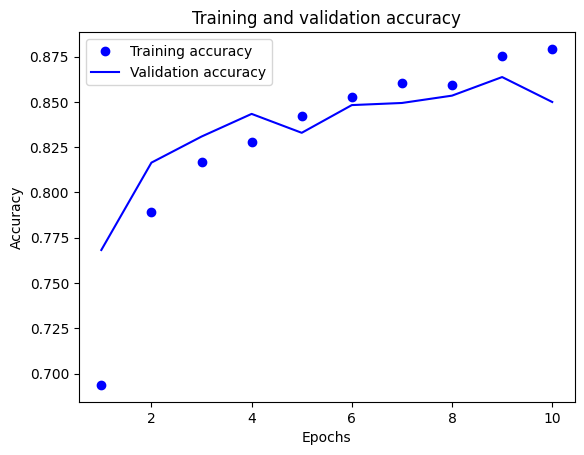

In [22]:
basic_gender_results = gender_model.load_weights('checkpoints/gender_model_basic.h5')
plot_accuracy(gender_results.history['accuracy'], gender_results.history['val_accuracy'])

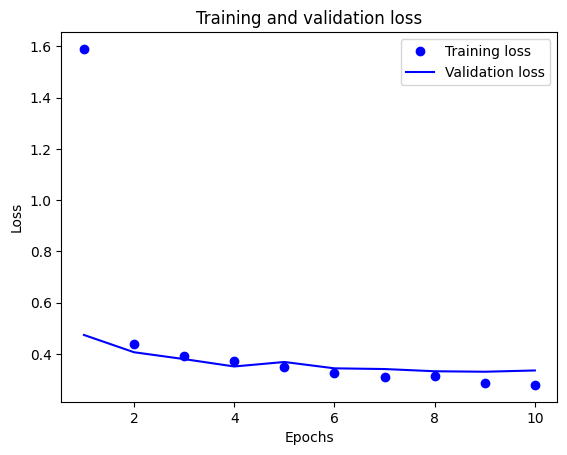

In [23]:
plot_loss(gender_results.history['loss'], gender_results.history['val_loss'])

129/129 [==============================] - 12s 91ms/step
Accuracy: 85.25267249757046
Precision: 0.8679900744416873
Recall: 0.8368421052631579
F1 Score: 0.8521315468940316
Confusion Matrix:


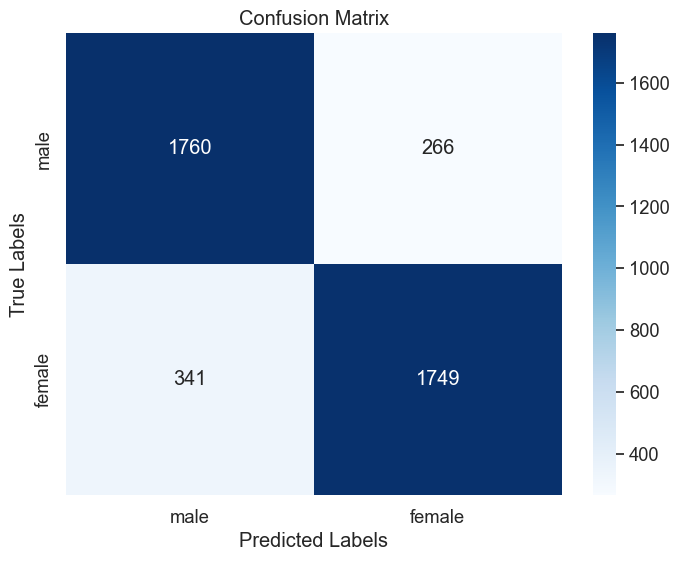

In [17]:
#gender results
gender_model.load_weights('checkpoints/gender_model_basic.h5')
g_pred = gender_model.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

Age accuracy and loss and accuracy on test set

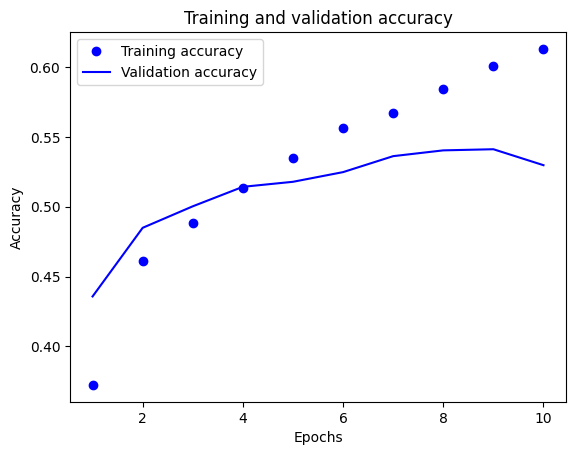

In [28]:
basic_age_results = age_model.load_weights('checkpoints/age_model_basic.h5')
plot_accuracy(age_results.history['accuracy'], age_results.history['val_accuracy'])

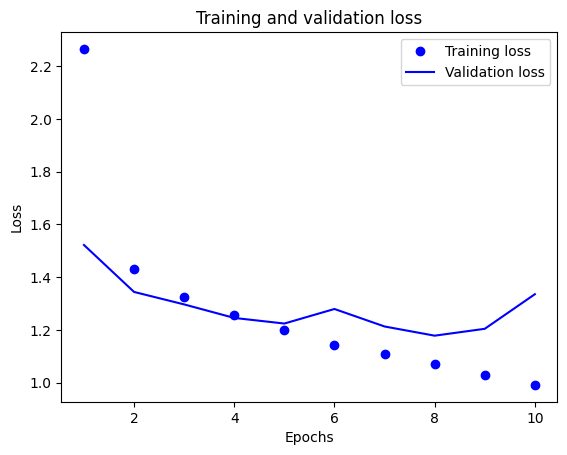

In [29]:
plot_loss(age_results.history['loss'], age_results.history['val_loss'])

129/129 [==============================] - 12s 91ms/step
Accuracy: 52.25947521865889
Precision: 0.5199166988365761
Recall: 0.5225947521865889
F1 Score: 0.5042796191730051
Confusion Matrix:


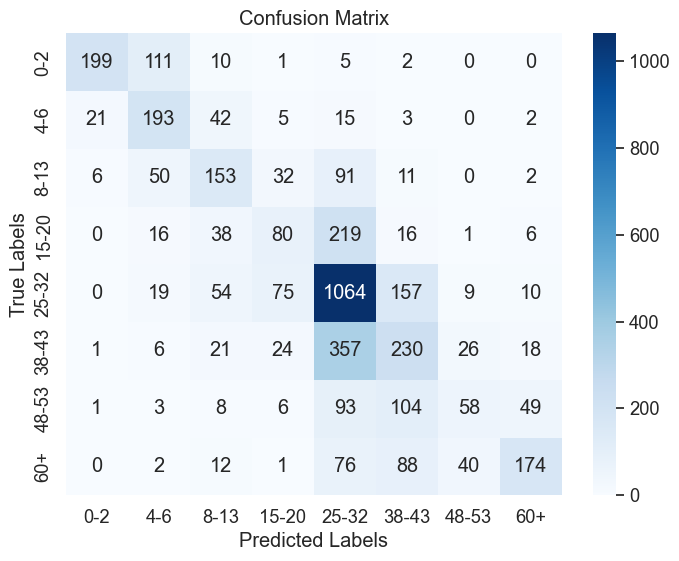

In [18]:
#age results
age_model.load_weights('checkpoints/age_model_basic.h5')
a_pred = age_model.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

In [31]:
age_model.save_weights('checkpoints/age_model_basic.h5')
gender_model.save_weights('checkpoints/gender_model_basic.h5')

After creating the basic model, I trained the resnet50 model and vgg16 model using the same dense layers to get a rough estimate of how well my model is doing against the pretrained layers.

<h4>Resnet50 model </h4>

In [19]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

with tf.device('/GPU:0'):
    age_resnet50_model = tf.keras.Sequential([
        resnet_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])


    gender_resnet50_model = tf.keras.Sequential([
        resnet_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])

input_shape = (None, 224, 224, 3)
age_resnet50_model.build(input_shape)
gender_resnet50_model.build(input_shape)
age_resnet50_model.summary()
gender_resnet50_model.summary()
age_resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gender_resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
Total params: 23,858,760
Trainable params: 23,805,640
Non-trainable params: 53,120
_____________________________________

In [ ]:
import tensorflow as tf
with tf.device('/GPU:0'): 
    gender_results = gender_resnet50_model.fit(train_gender_dataset, validation_data=val_gender_dataset, epochs=10)

Epoch 1/10
811/811 [==============================] - 233s 280ms/step - loss: 0.3104 - accuracy: 0.8612 - val_loss: 0.3228 - val_accuracy: 0.8549
Epoch 2/10
811/811 [==============================] - 228s 280ms/step - loss: 0.1669 - accuracy: 0.9326 - val_loss: 0.3387 - val_accuracy: 0.8608
Epoch 3/10
811/811 [==============================] - 227s 279ms/step - loss: 0.1134 - accuracy: 0.9578 - val_loss: 0.3297 - val_accuracy: 0.8813
Epoch 4/10
811/811 [==============================] - 230s 283ms/step - loss: 0.0901 - accuracy: 0.9669 - val_loss: 0.3662 - val_accuracy: 0.8944
Epoch 5/10
811/811 [==============================] - 229s 282ms/step - loss: 0.0696 - accuracy: 0.9747 - val_loss: 0.3467 - val_accuracy: 0.8900
Epoch 6/10
811/811 [==============================] - 227s 280ms/step - loss: 0.0546 - accuracy: 0.9811 - val_loss: 0.6223 - val_accuracy: 0.8549
Epoch 7/10
811/811 [==============================] - 228s 280ms/step - loss: 0.0499 - accuracy: 0.9819 - val_loss: 0.3969 -

In [ ]:
import tensorflow as tf
with tf.device('/GPU:0'):
    age_results = age_resnet50_model.fit(train_age_dataset, validation_data=val_age_dataset ,epochs=10)

Epoch 1/10
811/811 [==============================] - 3754s 5s/step - loss: 0.3610 - accuracy: 0.8596 - val_loss: 1.6002 - val_accuracy: 0.5771
Epoch 2/10
811/811 [==============================] - 4064s 5s/step - loss: 0.2797 - accuracy: 0.8941 - val_loss: 1.7231 - val_accuracy: 0.5527
Epoch 3/10
811/811 [==============================] - 4003s 5s/step - loss: 0.2488 - accuracy: 0.9059 - val_loss: 1.5971 - val_accuracy: 0.5471
Epoch 4/10
811/811 [==============================] - 4642s 6s/step - loss: 0.2005 - accuracy: 0.9251 - val_loss: 1.8017 - val_accuracy: 0.5864
Epoch 5/10
811/811 [==============================] - 4376s 5s/step - loss: 0.1718 - accuracy: 0.9365 - val_loss: 2.2115 - val_accuracy: 0.5308
Epoch 6/10
811/811 [==============================] - 4406s 5s/step - loss: 0.1531 - accuracy: 0.9465 - val_loss: 1.7546 - val_accuracy: 0.5992
Epoch 7/10
811/811 [==============================] - 4340s 5s/step - loss: 0.1337 - accuracy: 0.9521 - val_loss: 1.9987 - val_accuracy:

In [ ]:
age_resnet50_model.save_weights('checkpoints/age_resnet50_model_basic.h5')
gender_resnet50_model.save_weights('checkpoints/gender_resnet50_model_basic.h5')

129/129 [==============================] - 102s 779ms/step
Accuracy: 57.87172011661808
Precision: 0.607627788729298
Recall: 0.5787172011661808
F1 Score: 0.5591434967482205
Confusion Matrix:


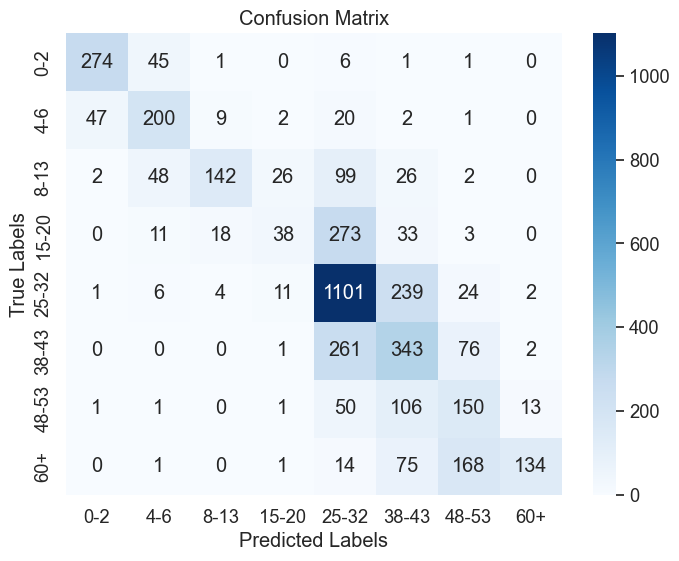

In [20]:
age_resnet50_model.load_weights('checkpoints/age_resnet50_model_basic.h5')
a_pred = age_resnet50_model.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
test_ay = np.asarray(test_ay).astype(np.float32)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

129/129 [==============================] - 95s 729ms/step
Accuracy: 89.57725947521867
Precision: 0.9491617090319091
Recall: 0.8397129186602871
F1 Score: 0.891089108910891
Confusion Matrix:


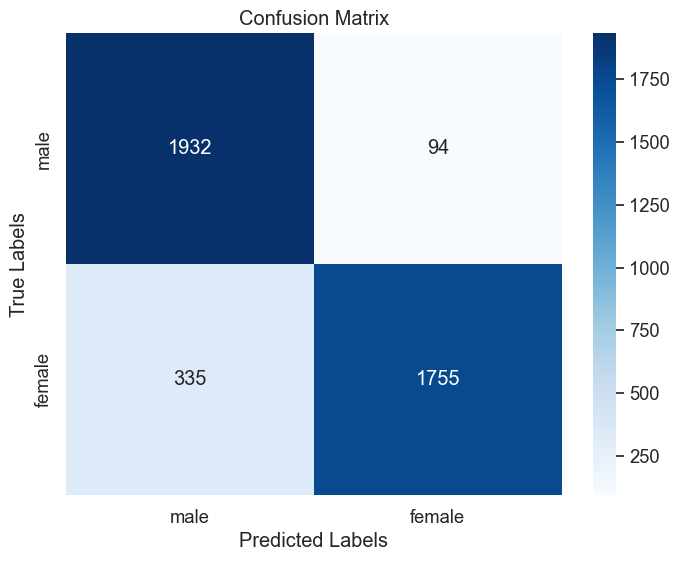

In [21]:
gender_resnet50_model.load_weights('checkpoints/gender_resnet50_model_basic.h5')
g_pred = gender_resnet50_model.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

<h4>VGG16 model</h4>

In [22]:
vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

age_vgg16_model = tf.keras.Sequential([
    vgg_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

gender_vgg16_model = tf.keras.Sequential([
        vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])


input_shape = (None, 224, 224, 3)
age_vgg16_model.build(input_shape)
gender_vgg16_model.build(input_shape)
age_vgg16_model.summary()
gender_vgg16_model.summary()
age_vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gender_vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
Total params: 14,789,128
Trainable params: 14,789,128
Non-trainable params: 0
__________________________________________

In [20]:
with tf.device('/GPU:0'):
    age_vgg_results = age_vgg16_model.fit(train_age_dataset, validation_data=val_age_dataset ,epochs=10)
    gender_vgg_results = gender_vgg16_model.fit(train_gender_dataset, validation_data=val_gender_dataset ,epochs=10)

Epoch 1/10
811/811 [==============================] - ETA: 0s - loss: 2.3443 - accuracy: 0.3347WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001CA8A0EE558> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
811/811 [==============================] - 7924s 10s/step - loss: 2.3443 - accuracy: 0.3347 - val_loss: 1.8396 - val_accuracy: 0.3

In [21]:
age_vgg16_model.save_weights('checkpoints/age_vgg_model_basic.h5')
gender_vgg16_model.save_weights('checkpoints/gender_vgg_model_basic.h5')

129/129 [==============================] - 152s 1s/step
Accuracy: 32.288629737609334
Precision: 0.24493115821766331
Recall: 0.3228862973760933
F1 Score: 0.20533827959526105
Confusion Matrix:


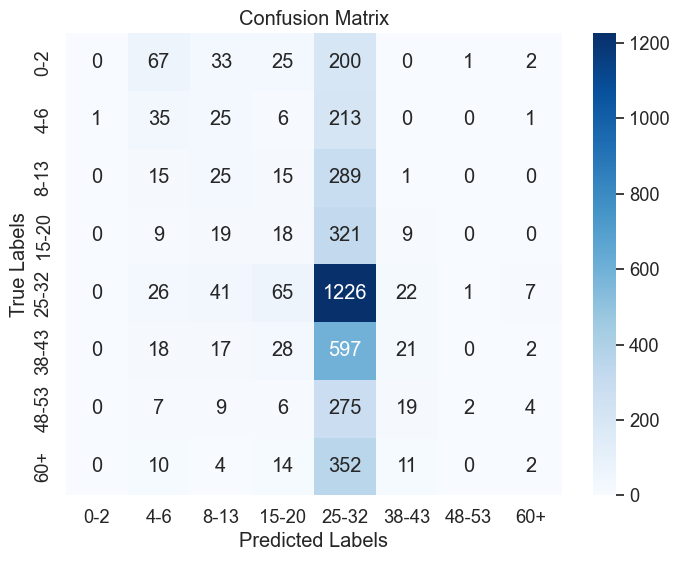

In [87]:
age_vgg16_model.load_weights('checkpoints/age_vgg_model_basic.h5')
a_pred = age_vgg16_model.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
test_ay = np.asarray(test_ay).astype(np.float32)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

129/129 [==============================] - 144s 1s/step
Accuracy: 84.62099125364432
Precision: 0.938591210114389
Recall: 0.745933014354067
F1 Score: 0.831245001332978
Confusion Matrix:


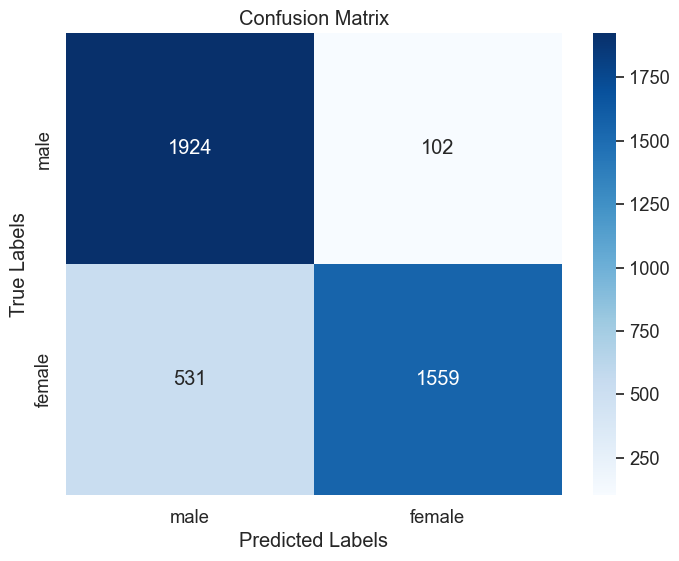

In [76]:
gender_vgg16_model.load_weights('checkpoints/gender_vgg_model_basic.h5')
g_pred = gender_vgg16_model.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

<p>
After training the first basic model, I want to first test how effective fine tuning the model is.
<br>
To do this, I plan to first fine tune all the layers in my model and get the results after 10 epochs of training.
<br>
Next, I plan to freeze the dense layers and fine tune my custom feature extractor and get the results after 10 epochs of training.
<br> 
Finally I will freeze the custom feature extractor layer and fine tune the dense layers. I will get the results and compare and see which method is the most effective for my model in this case.
</p>

The first one will fine tune all the layers in the model

In [32]:
# load the weights
age_model.load_weights("checkpoints/age_model_basic.h5")
gender_model.load_weights("checkpoints/gender_model_basic.h5")

# fine tune the model and save the weights

age_fine_all_results = age_model.fit(train_age_dataset, validation_data= val_age_dataset ,epochs=10)
gender_fine_all_results = gender_model.fit(train_gender_dataset, validation_data= val_gender_dataset ,epochs=10)

age_model.save("checkpoints/age_model_fine_all.h5")
gender_model.save("checkpoints/gender_model_fine_all.h5")

Epoch 1/10
811/811 [==============================] - 288s 356ms/step - loss: 1.7117 - accuracy: 0.3826 - val_loss: 1.4110 - val_accuracy: 0.4464
Epoch 2/10
811/811 [==============================] - 300s 370ms/step - loss: 1.2948 - accuracy: 0.5008 - val_loss: 1.2445 - val_accuracy: 0.5165
Epoch 3/10
811/811 [==============================] - 294s 363ms/step - loss: 1.1868 - accuracy: 0.5376 - val_loss: 1.2328 - val_accuracy: 0.5243
Epoch 4/10
811/811 [==============================] - 300s 370ms/step - loss: 1.0849 - accuracy: 0.5750 - val_loss: 1.2284 - val_accuracy: 0.5290
Epoch 5/10
811/811 [==============================] - 301s 371ms/step - loss: 1.0132 - accuracy: 0.6039 - val_loss: 1.2413 - val_accuracy: 0.5337
Epoch 6/10
811/811 [==============================] - 300s 370ms/step - loss: 0.9592 - accuracy: 0.6257 - val_loss: 1.2132 - val_accuracy: 0.5326
Epoch 7/10
811/811 [==============================] - 287s 354ms/step - loss: 0.9010 - accuracy: 0.6457 - val_loss: 1.2881 -

Gender results on the test set after fine tuning all layers

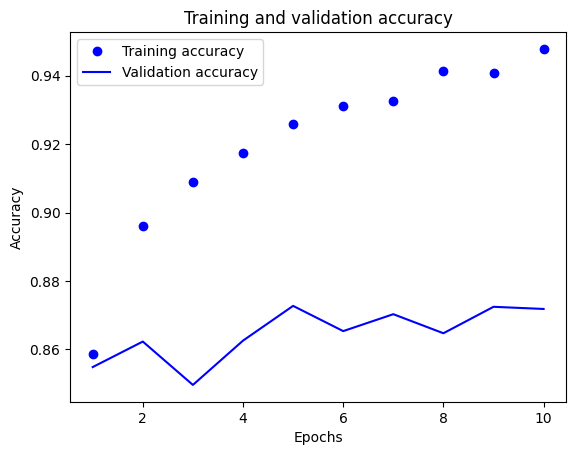

In [33]:
plot_accuracy(gender_fine_all_results.history['accuracy'], gender_fine_all_results.history['val_accuracy'])

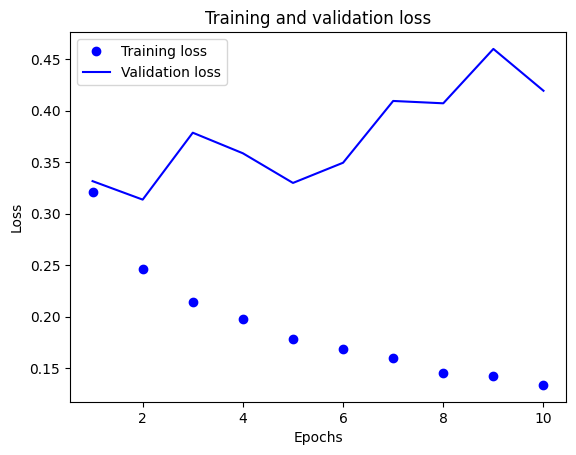

In [34]:
plot_loss(gender_fine_all_results.history['loss'], gender_fine_all_results.history['val_loss'])

129/129 [==============================] - 11s 81ms/step
Accuracy: 87.29348882410108
Precision: 0.8947103274559194
Recall: 0.8497607655502393
F1 Score: 0.8716564417177914
Confusion Matrix:


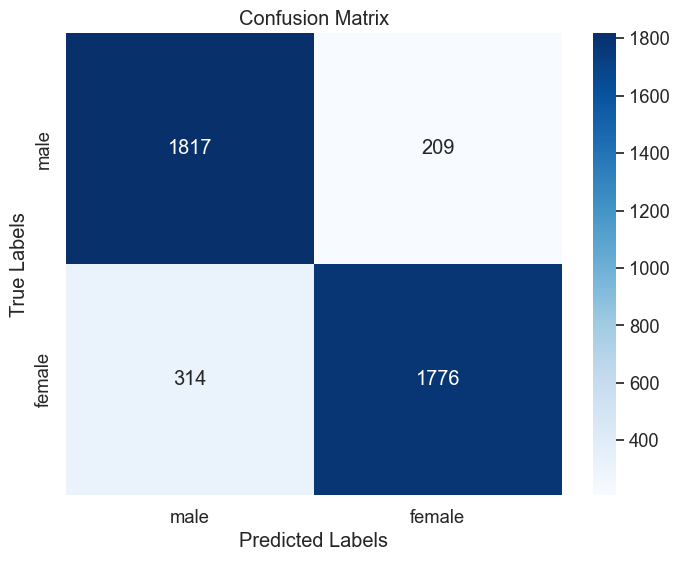

In [77]:
#gender results
gender_model.load_weights("checkpoints/gender_model_fine_all.h5")
g_pred = gender_model.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

Age results on the test set after fine tuning all layers

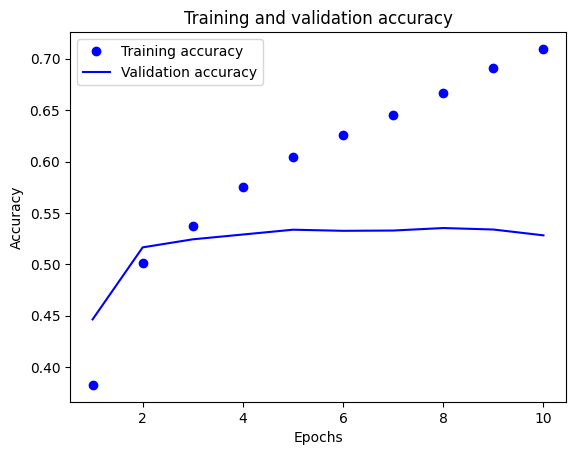

In [36]:
plot_accuracy(age_fine_all_results.history['accuracy'], age_fine_all_results.history['val_accuracy'])

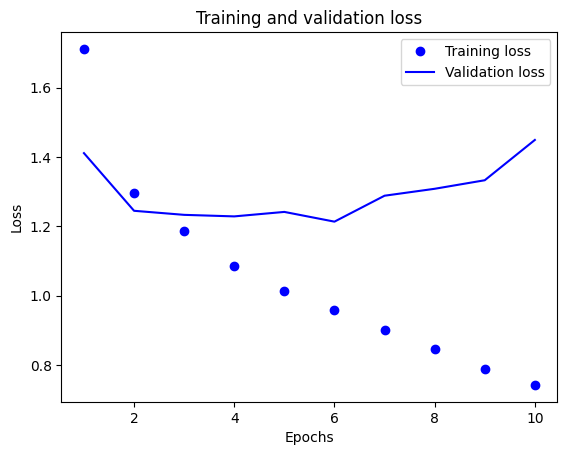

In [37]:
plot_loss(age_fine_all_results.history['loss'], age_fine_all_results.history['val_loss'])

129/129 [==============================] - 10s 81ms/step
Accuracy: 52.332361516034986
Precision: 0.5179117298420837
Recall: 0.5233236151603499
F1 Score: 0.5098803012462473
Confusion Matrix:


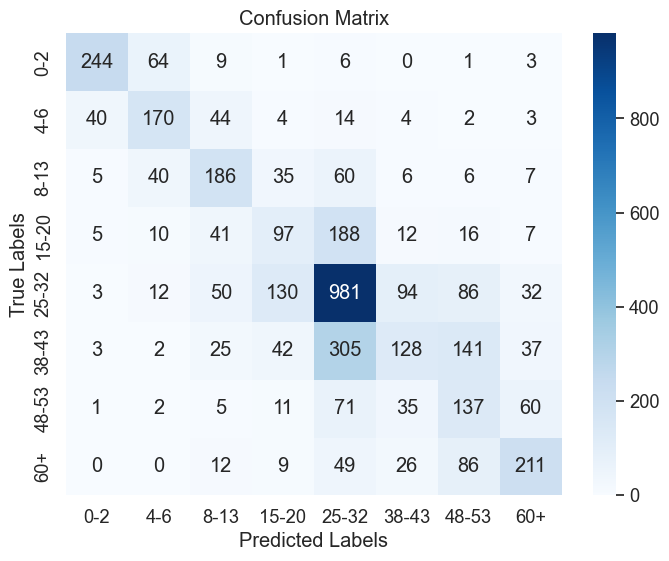

In [88]:
#age results
age_model.load_weights("checkpoints/age_model_fine_all.h5")
a_pred = age_model.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

Freezing the dense layers and fine tuning the custom feature extractor

In [39]:
# load the weights
age_model.load_weights("checkpoints/age_model_basic.h5")
gender_model.load_weights("checkpoints/gender_model_basic.h5")

# freeze the dense layers
for layer in age_model.layers[1:]:
    layer.trainable = False

for layer in gender_model.layers[1:]:
    layer.trainable = False


# fine tune the model and save the weights
age_fine_custom_results = age_model.fit(train_age_dataset, validation_data= val_age_dataset ,epochs=10)
gender_fine_custom_results = gender_model.fit(train_gender_dataset, validation_data= val_gender_dataset ,epochs=10)

age_model.save("checkpoints/age_model_fine_dense_freeze.h5")
gender_model.save("checkpoints/gender_model_dense_freeze.h5")

Epoch 1/10
811/811 [==============================] - 299s 368ms/step - loss: 1.0753 - accuracy: 0.5815 - val_loss: 1.2141 - val_accuracy: 0.5325
Epoch 2/10
811/811 [==============================] - 299s 369ms/step - loss: 0.9686 - accuracy: 0.6204 - val_loss: 1.2684 - val_accuracy: 0.5084
Epoch 3/10
811/811 [==============================] - 291s 359ms/step - loss: 0.9052 - accuracy: 0.6440 - val_loss: 1.2394 - val_accuracy: 0.5278
Epoch 4/10
811/811 [==============================] - 290s 358ms/step - loss: 0.8555 - accuracy: 0.6644 - val_loss: 1.3042 - val_accuracy: 0.5324
Epoch 5/10
811/811 [==============================] - 288s 355ms/step - loss: 0.8092 - accuracy: 0.6844 - val_loss: 1.3183 - val_accuracy: 0.5415
Epoch 6/10
811/811 [==============================] - 289s 356ms/step - loss: 0.7523 - accuracy: 0.7068 - val_loss: 1.3839 - val_accuracy: 0.5431
Epoch 7/10
811/811 [==============================] - 286s 352ms/step - loss: 0.6900 - accuracy: 0.7324 - val_loss: 1.5723 -

Gender results on the test set after fine tuning the custom feature extractor layer

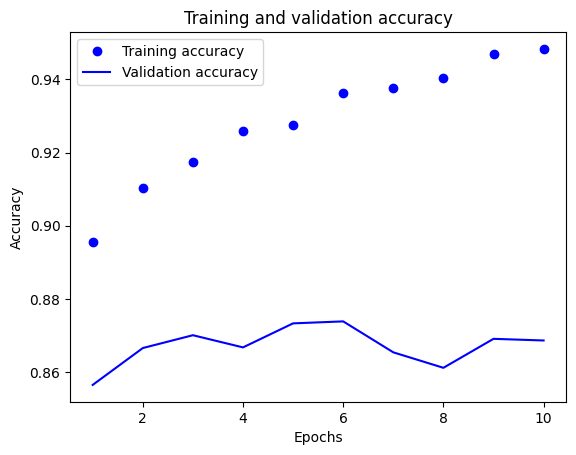

In [40]:
plot_accuracy(gender_fine_custom_results.history['accuracy'], gender_fine_custom_results.history['val_accuracy'])

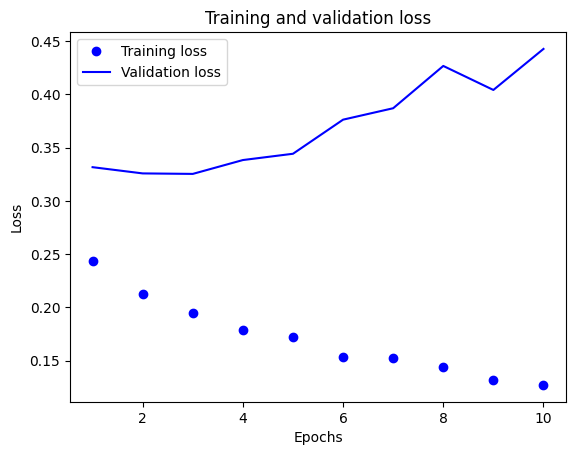

In [41]:
plot_loss(gender_fine_custom_results.history['loss'], gender_fine_custom_results.history['val_loss'])

129/129 [==============================] - 10s 79ms/step
Accuracy: 87.12342079689019
Precision: 0.9083769633507853
Recall: 0.8301435406698564
F1 Score: 0.8675
Confusion Matrix:


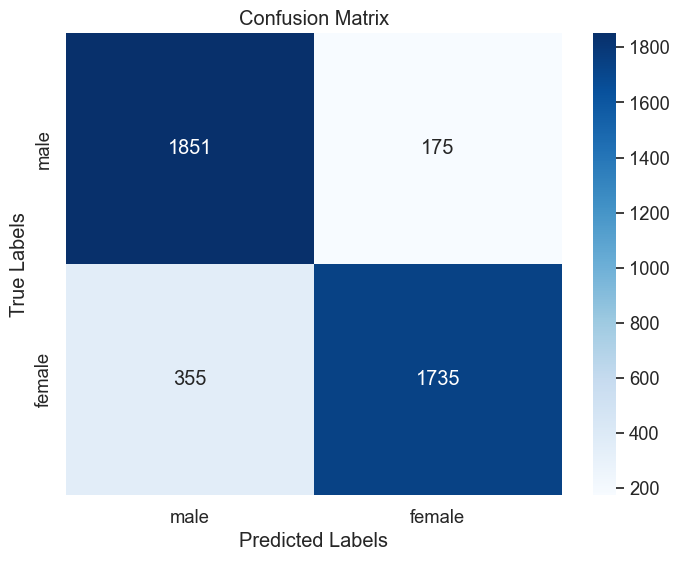

In [78]:
#gender results
gender_model.load_weights("checkpoints/gender_model_dense_freeze.h5")
g_pred = gender_model.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

Age results on the test set after fine tuning the custom feature extractor layer

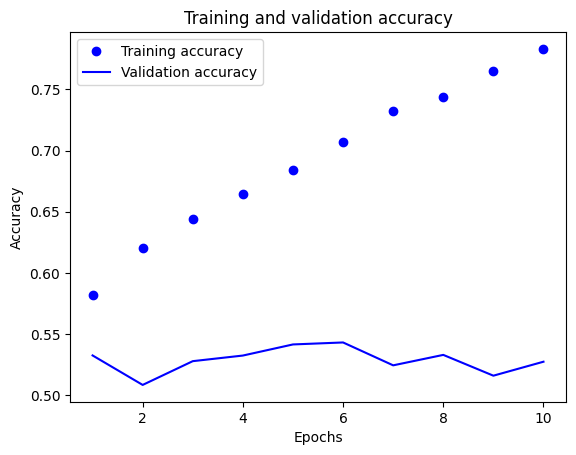

In [43]:
plot_accuracy(age_fine_custom_results.history['accuracy'], age_fine_custom_results.history['val_accuracy'])

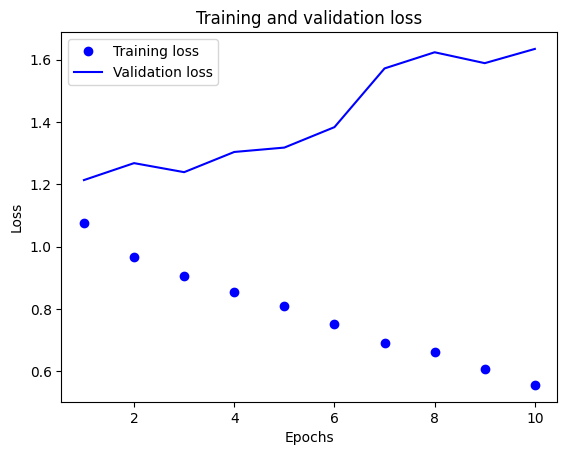

In [44]:
plot_loss(age_fine_custom_results.history['loss'], age_fine_custom_results.history['val_loss'])

129/129 [==============================] - 10s 81ms/step
Accuracy: 52.28377065111759
Precision: 0.5147274544530626
Recall: 0.5228377065111759
F1 Score: 0.5165819231477553
Confusion Matrix:


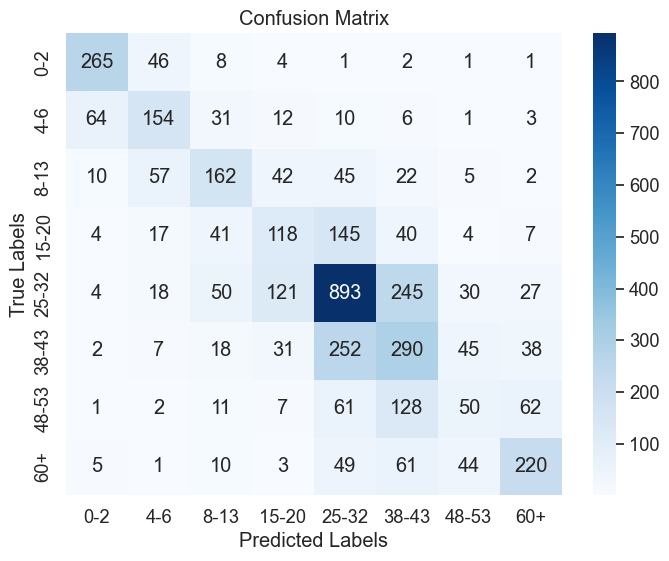

In [89]:
#age results
age_model.load_weights("checkpoints/age_model_fine_dense_freeze.h5")
a_pred = age_model.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

Freezing the custom feature extractor layer and fine tuning the dense layers

In [52]:
# load the pretrained weights
age_model.load_weights("checkpoints/age_model_basic.h5")
gender_model.load_weights("checkpoints/gender_model_basic.h5")

age_model.layers[0].set_trainable(False)
gender_model.layers[0].set_trainable(False)
    
for layer in age_model.layers[1:]:
    layer.trainable = True

for layer in gender_model.layers[1:]:
    layer.trainable = True


# fine tuning of model

age_fine_dense_results = age_model.fit(train_age_dataset, validation_data= val_age_dataset ,epochs=10)
gender_fine_dense_results = gender_model.fit(train_gender_dataset, validation_data= val_gender_dataset ,epochs=10)

age_model.save("checkpoints/age_model_fine_custom_freeze.h5")
gender_model.save("checkpoints/gender_model_fine_custom_freeze.h5")

Epoch 1/10
811/811 [==============================] - 302s 372ms/step - loss: 0.9420 - accuracy: 0.6270 - val_loss: 1.2650 - val_accuracy: 0.5383
Epoch 2/10
811/811 [==============================] - 295s 363ms/step - loss: 0.9003 - accuracy: 0.6455 - val_loss: 1.2404 - val_accuracy: 0.5307
Epoch 3/10
811/811 [==============================] - 287s 354ms/step - loss: 0.8542 - accuracy: 0.6636 - val_loss: 1.3033 - val_accuracy: 0.5311
Epoch 4/10
811/811 [==============================] - 295s 364ms/step - loss: 0.8209 - accuracy: 0.6766 - val_loss: 1.3592 - val_accuracy: 0.5307
Epoch 5/10
811/811 [==============================] - 295s 364ms/step - loss: 0.7812 - accuracy: 0.6934 - val_loss: 1.4245 - val_accuracy: 0.5337
Epoch 6/10
811/811 [==============================] - 299s 369ms/step - loss: 0.7431 - accuracy: 0.7099 - val_loss: 1.4413 - val_accuracy: 0.5390
Epoch 7/10
811/811 [==============================] - 304s 375ms/step - loss: 0.6983 - accuracy: 0.7276 - val_loss: 1.7701 -

Gender results on the test set after fine tuning with the weights of the custom feature extractor frozen

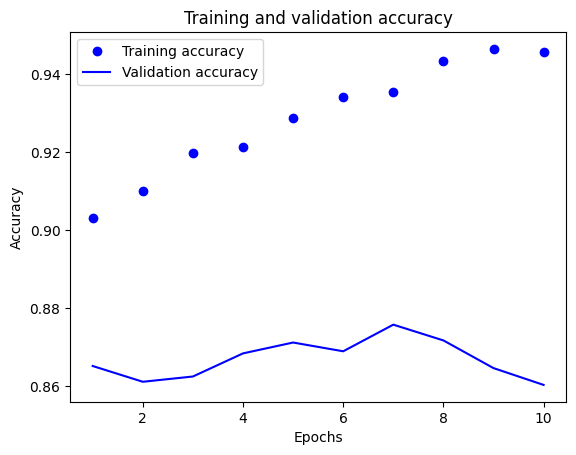

In [53]:
plot_accuracy(gender_fine_dense_results.history['accuracy'], gender_fine_dense_results.history['val_accuracy'])

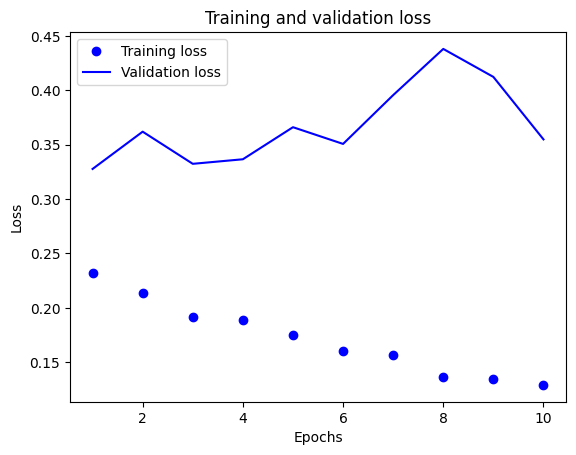

In [54]:
plot_loss(gender_fine_dense_results.history['loss'], gender_fine_dense_results.history['val_loss'])

129/129 [==============================] - 10s 80ms/step
Accuracy: 86.80758017492711
Precision: 0.8695652173913043
Recall: 0.8708133971291866
F1 Score: 0.8701888596700932
Confusion Matrix:


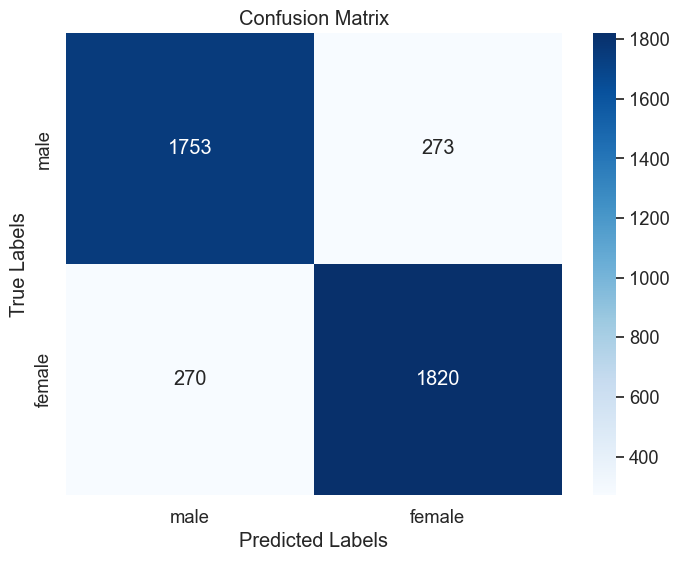

In [79]:
#gender results
gender_model.load_weights("checkpoints/gender_model_fine_custom_freeze.h5")
g_pred = gender_model.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

Age results on the test set after fine tuning with the weights of the custom feature extractor frozen

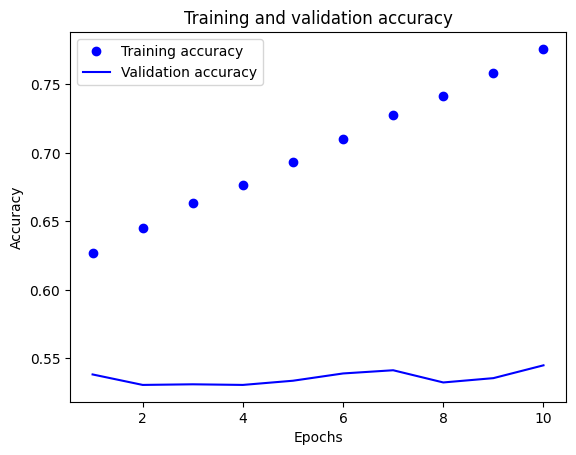

In [56]:
plot_accuracy(age_fine_dense_results.history['accuracy'], age_fine_dense_results.history['val_accuracy'])

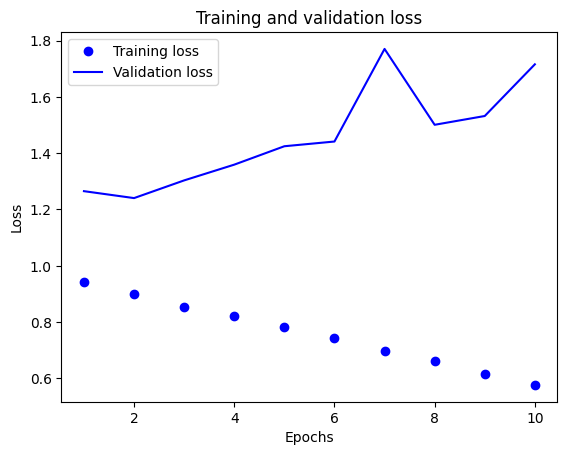

In [57]:
plot_loss(age_fine_dense_results.history['loss'], age_fine_dense_results.history['val_loss'])

129/129 [==============================] - 10s 80ms/step
Accuracy: 53.06122448979592
Precision: 0.5224505609290824
Recall: 0.5306122448979592
F1 Score: 0.5172938107126568
Confusion Matrix:


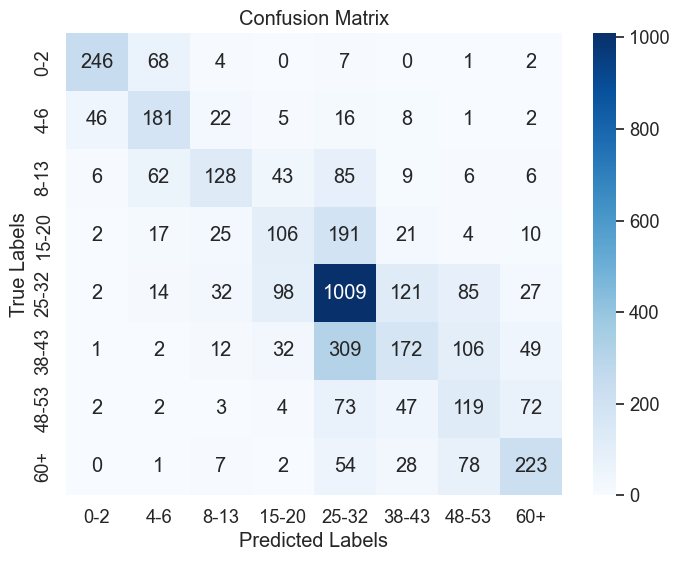

In [90]:
#age results
age_model.load_weights("checkpoints/age_model_fine_custom_freeze.h5")
a_pred = age_model.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

<p>As seen from the results above the model is overfitting so my next experiment is to add dropout and batch normalisation to the model to stop the model from overfitting. Using the previous experiment to help aid the issue I decided to first train for 10 epochs then freezing the feature extractor and training the dense layers as it was the most effective in increasing the accuracy.</p>

In [23]:
class custom_feature_extractor2(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super(custom_feature_extractor2, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv1 = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=(224, 224, 3))
        self.maxpool1 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.maxpool3 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))
        self.conv4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.maxpool4 = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self, img):
        x = self.conv1(img)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.flatten(x)
        return x
    
    def set_trainable(self, trainable):
        layers_to_train = [self.conv1, self.maxpool1, self.conv2, self.maxpool2, self.conv3, self.maxpool3, self.conv4, self.maxpool4]
        for layer in layers_to_train:
            layer.trainable = trainable
            

with tf.device('/GPU:0'):
    age_model_2 = tf.keras.Sequential([
        custom_feature_extractor2(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation='softmax')
    ])
    
    gender_model_2 = tf.keras.Sequential([
        custom_feature_extractor2(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation='softmax')
    ])
    
input_shape = (None, 224, 224, 3)
BS = 16
age_model_2.build(input_shape)
gender_model_2.build(input_shape)
age_model_2.summary()
gender_model_2.summary()
age_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gender_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_feature_extractor2 (  (None, 18432)            1558656   
 custom_feature_extractor2)                                      
                                                                 
 dense_18 (Dense)            (None, 128)               2359424   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [17]:
age_model_2_results = age_model_2.fit(train_age_dataset, validation_data=val_age_dataset ,epochs=10)
gender_model_2_results = gender_model_2.fit(train_gender_dataset, validation_data=val_gender_dataset ,epochs=10)

age_model_2.save("checkpoints/age_model_2.h5")
gender_model_2.save("checkpoints/gender_model_2.h5")

Epoch 1/10
811/811 [==============================] - 291s 357ms/step - loss: 1.9863 - accuracy: 0.3037 - val_loss: 8.3837 - val_accuracy: 0.3342
Epoch 2/10
811/811 [==============================] - 288s 356ms/step - loss: 1.7451 - accuracy: 0.3667 - val_loss: 1.6276 - val_accuracy: 0.4010
Epoch 3/10
811/811 [==============================] - 291s 359ms/step - loss: 1.5975 - accuracy: 0.4061 - val_loss: 2.0546 - val_accuracy: 0.3891
Epoch 4/10
811/811 [==============================] - 296s 365ms/step - loss: 1.4809 - accuracy: 0.4378 - val_loss: 1.5832 - val_accuracy: 0.4467
Epoch 5/10
811/811 [==============================] - 298s 367ms/step - loss: 1.4243 - accuracy: 0.4551 - val_loss: 1.3268 - val_accuracy: 0.4877
Epoch 6/10
811/811 [==============================] - 297s 366ms/step - loss: 1.3823 - accuracy: 0.4682 - val_loss: 1.2818 - val_accuracy: 0.4972
Epoch 7/10
811/811 [==============================] - 296s 365ms/step - loss: 1.3474 - accuracy: 0.4776 - val_loss: 1.5175 -

Age accuracy and loss graphs and accuracy score on test set

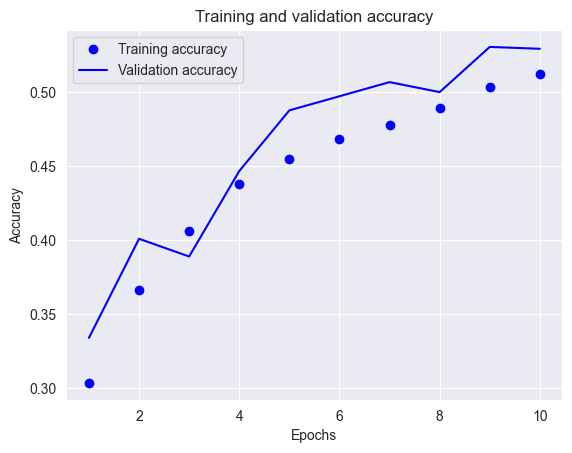

In [18]:
plot_accuracy(age_model_2_results.history['accuracy'], age_model_2_results.history['val_accuracy'])

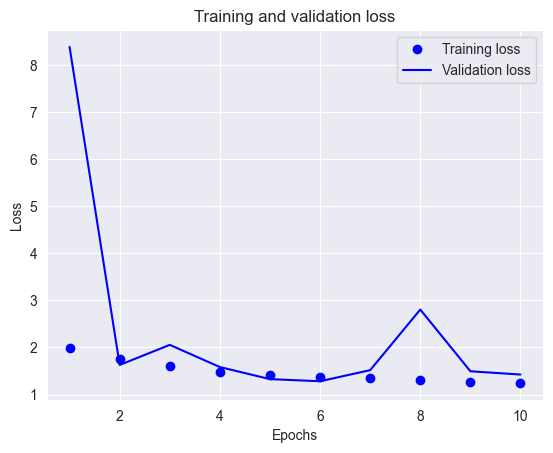

In [19]:
plot_loss(age_model_2_results.history['loss'], age_model_2_results.history['val_loss'])

129/129 [==============================] - 11s 81ms/step
Accuracy: 52.59961127308066
Precision: 0.4691192543297277
Recall: 0.5259961127308066
F1 Score: 0.4489617258841823
Confusion Matrix:


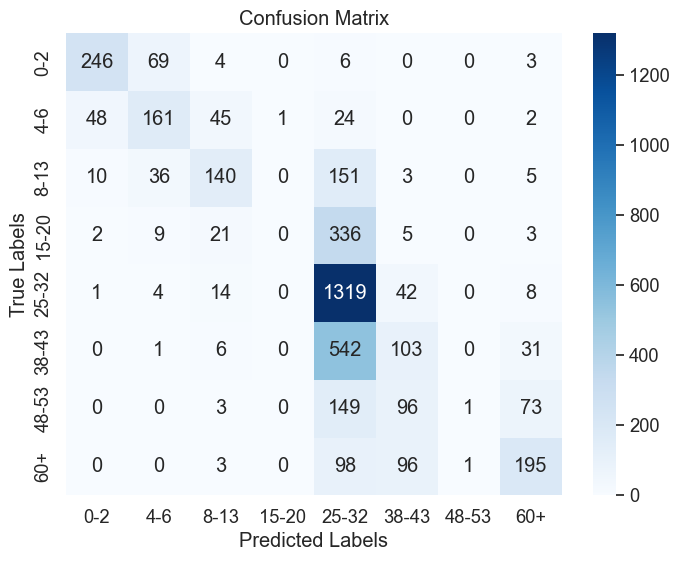

In [91]:
#age results
age_model_2.load_weights("checkpoints/age_model_2.h5")
a_pred = age_model_2.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

Gender accuracy and loss graphs and accuracy score on test set

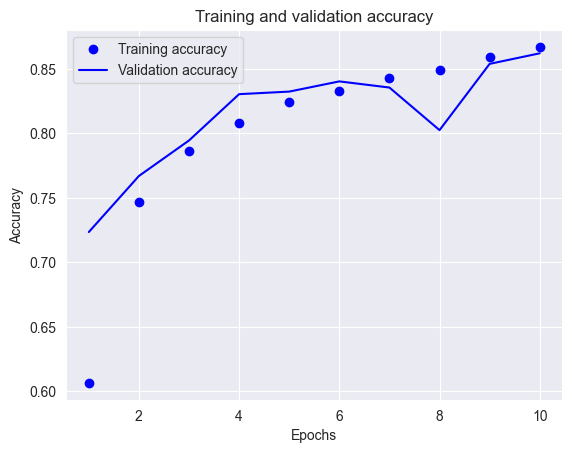

In [21]:
plot_accuracy(gender_model_2_results.history['accuracy'], gender_model_2_results.history['val_accuracy'])

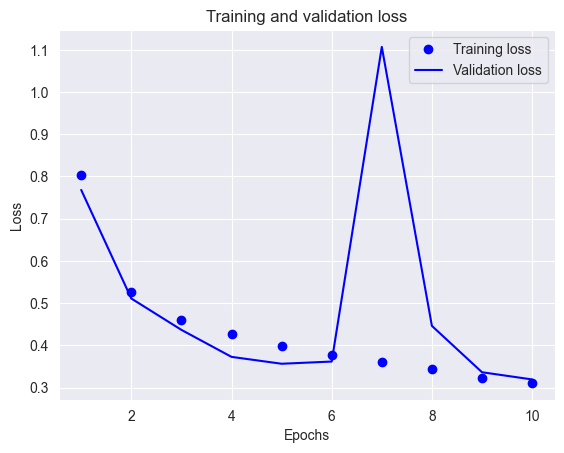

In [22]:
plot_loss(gender_model_2_results.history['loss'], gender_model_2_results.history['val_loss'])

129/129 [==============================] - 11s 82ms/step
Accuracy: 85.54421768707483
Precision: 0.9404832056570418
Recall: 0.7636363636363637
F1 Score: 0.8428835489833642
Confusion Matrix:


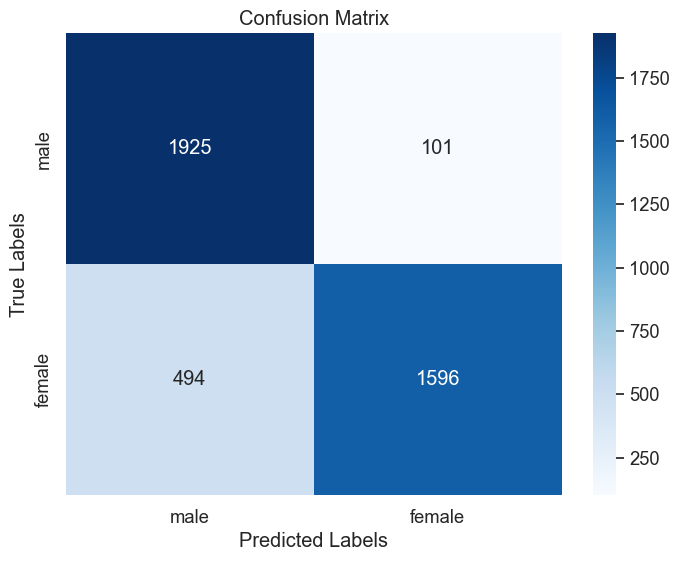

In [93]:
#gender results
gender_model_2.load_weights("checkpoints/gender_model_2.h5")
g_pred = gender_model_2.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

Fine tuning of model by freezing the custom feature extractor

In [24]:
# load the pretrained weights
age_model_2.load_weights("checkpoints/age_model_2.h5")
gender_model_2.load_weights("checkpoints/gender_model_2.h5")

age_model_2.layers[0].set_trainable(False)
gender_model_2.layers[0].set_trainable(False)
    
for layer in age_model_2.layers[1:]:
    layer.trainable = True

for layer in gender_model_2.layers[1:]:
    layer.trainable = True


# fine-tuning of model

age_2_fine_results = age_model_2.fit(train_age_dataset, validation_data=val_age_dataset ,epochs=10)
gender_2_fine_results = gender_model_2.fit(train_gender_dataset, validation_data=val_gender_dataset ,epochs=10)

age_model_2.save("checkpoints/age_model_2_fine.h5")
gender_model_2.save("checkpoints/gender_model_2_fine.h5")

Epoch 1/10
811/811 [==============================] - 309s 381ms/step - loss: 1.2100 - accuracy: 0.5196 - val_loss: 1.2460 - val_accuracy: 0.5388
Epoch 2/10
811/811 [==============================] - 295s 364ms/step - loss: 1.1818 - accuracy: 0.5293 - val_loss: 1.3381 - val_accuracy: 0.5153
Epoch 3/10
811/811 [==============================] - 290s 358ms/step - loss: 1.1593 - accuracy: 0.5364 - val_loss: 1.3403 - val_accuracy: 0.4936
Epoch 4/10
811/811 [==============================] - 291s 358ms/step - loss: 1.1285 - accuracy: 0.5481 - val_loss: 1.4183 - val_accuracy: 0.5472
Epoch 5/10
811/811 [==============================] - 292s 360ms/step - loss: 1.1060 - accuracy: 0.5585 - val_loss: 1.3428 - val_accuracy: 0.5302
Epoch 6/10
811/811 [==============================] - 287s 354ms/step - loss: 1.0853 - accuracy: 0.5618 - val_loss: 1.1844 - val_accuracy: 0.5494
Epoch 7/10
811/811 [==============================] - 292s 359ms/step - loss: 1.0555 - accuracy: 0.5742 - val_loss: 1.3611 -

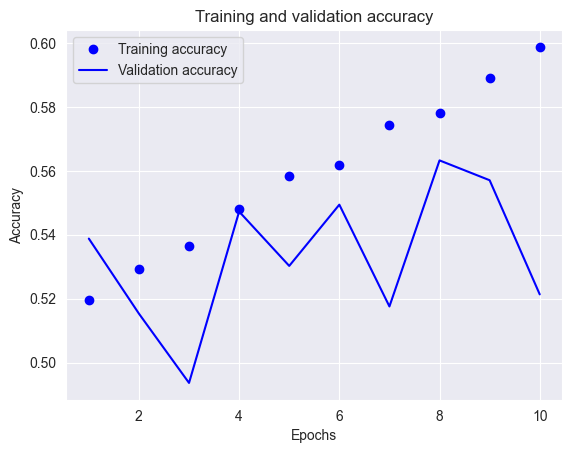

In [25]:
plot_accuracy(age_2_fine_results.history['accuracy'], age_2_fine_results.history['val_accuracy'])

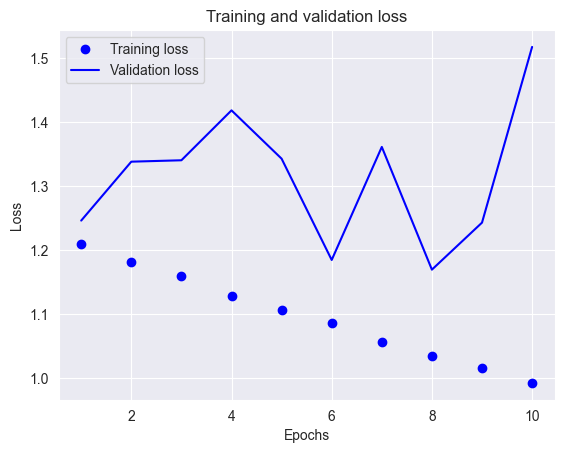

In [26]:
plot_loss(age_2_fine_results.history['loss'], age_2_fine_results.history['val_loss'])

129/129 [==============================] - 11s 86ms/step
Accuracy: 51.0932944606414
Precision: 0.5228060231486944
Recall: 0.510932944606414
F1 Score: 0.4803833571503367
Confusion Matrix:


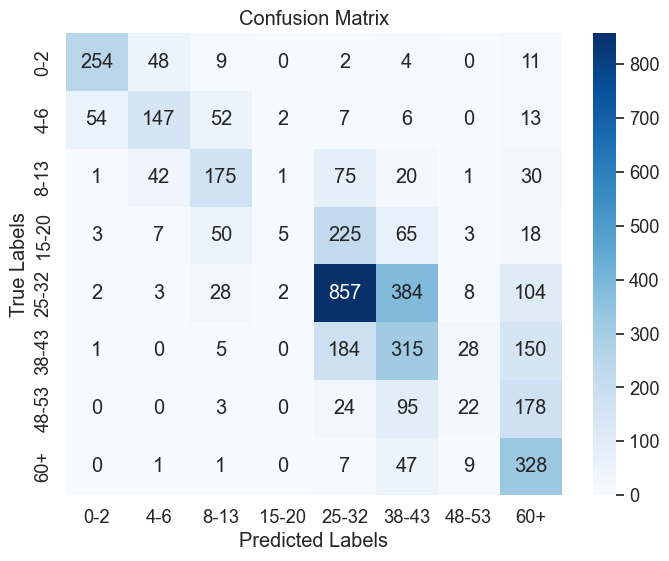

In [94]:
#age results
age_model_2.load_weights("checkpoints/age_model_2_fine.h5")
a_pred = age_model_2.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

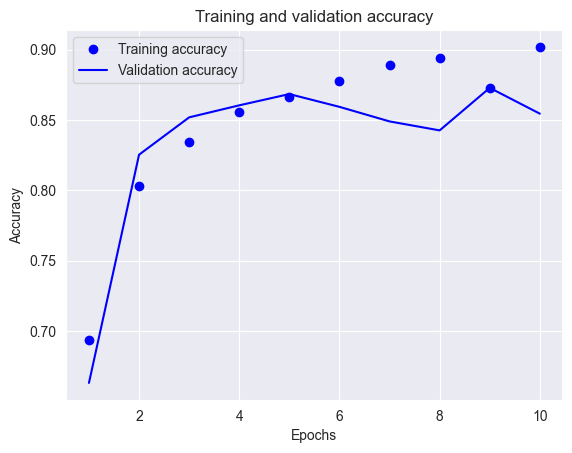

In [28]:
plot_accuracy(gender_2_fine_results.history['accuracy'], gender_2_fine_results.history['val_accuracy'])

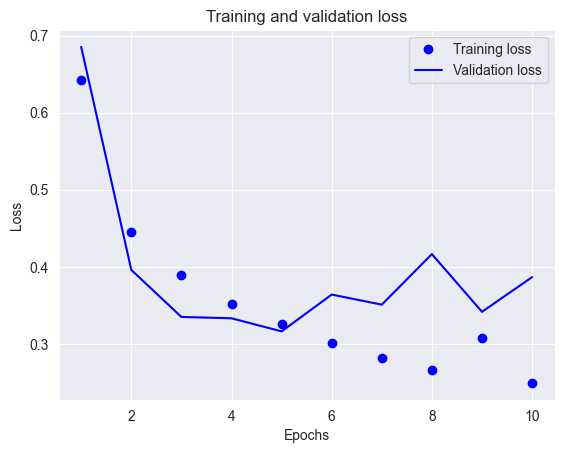

In [29]:
plot_loss(gender_2_fine_results.history['loss'], gender_2_fine_results.history['val_loss'])

129/129 [==============================] - 10s 80ms/step
Accuracy: 85.54421768707483
Precision: 0.9404832056570418
Recall: 0.7636363636363637
F1 Score: 0.8428835489833642
Confusion Matrix:


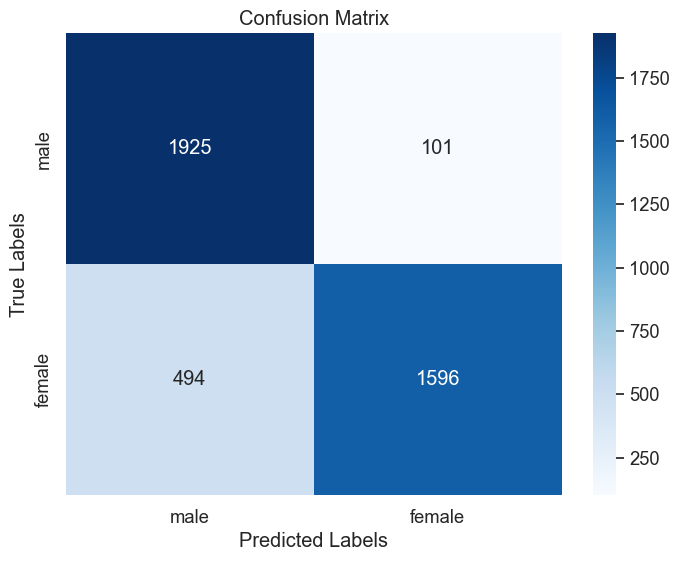

In [81]:
#gender results
gender_model_2.load_weights("checkpoints/gender_model_2_fine.h5")
g_pred = gender_model_2.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

From the previous experiment, even though I added regularisation, the model has some slight tendency to overfit on the training data and after I finetuned the model, it seems to do worse than before finetuning. I decided to proceed with a different method and add more layers and connections as well as to reduce the number of filters in my custom feature extractor.

In [24]:
class custom_feature_extractor3(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super(custom_feature_extractor3, self).__init__(**kwargs)

    def build(self, input_shape):
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3))
        self.maxpool1 = tf.keras.layers.MaxPooling2D((3, 3))
        self.batch_norm1 = tf.keras.layers.BatchNormalization(axis=-1)
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.batch_norm2 = tf.keras.layers.BatchNormalization(axis=-1)
        self.dropout2 = tf.keras.layers.Dropout(0.25)
        self.conv3 =  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.batch_norm3 = tf.keras.layers.BatchNormalization(axis=-1)
        self.maxpool3 = tf.keras.layers.MaxPooling2D((2, 2))
        self.dropout3 = tf.keras.layers.Dropout(0.25)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, img):
        x = self.conv1(img)
        x = self.batch_norm1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        return x

    def set_trainable(self, trainable):
        layers_to_train = [self.conv1, self.maxpool1, self.batch_norm1, self.conv2, self.maxpool2, self.batch_norm2, self.conv3, self.batch_norm3, self.maxpool3]
        for layer in layers_to_train:
            layer.trainable = trainable
            

with tf.device('/GPU:0'):
    age_model_3 = tf.keras.Sequential([
        custom_feature_extractor3(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.55),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.55),
        tf.keras.layers.Dense(8, activation='softmax')
    ])


    gender_model_3 = tf.keras.Sequential([
        custom_feature_extractor3(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
input_shape = (None, 224, 224, 3)
age_model_3.build(input_shape)
gender_model_3.build(input_shape)
age_model_3.summary()
gender_model_3.summary()
age_model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gender_model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_feature_extractor3 (  (None, 10368)            14656     
 custom_feature_extractor3)                                      
                                                                 
 dense_24 (Dense)            (None, 1024)              10617856  
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 1024)             

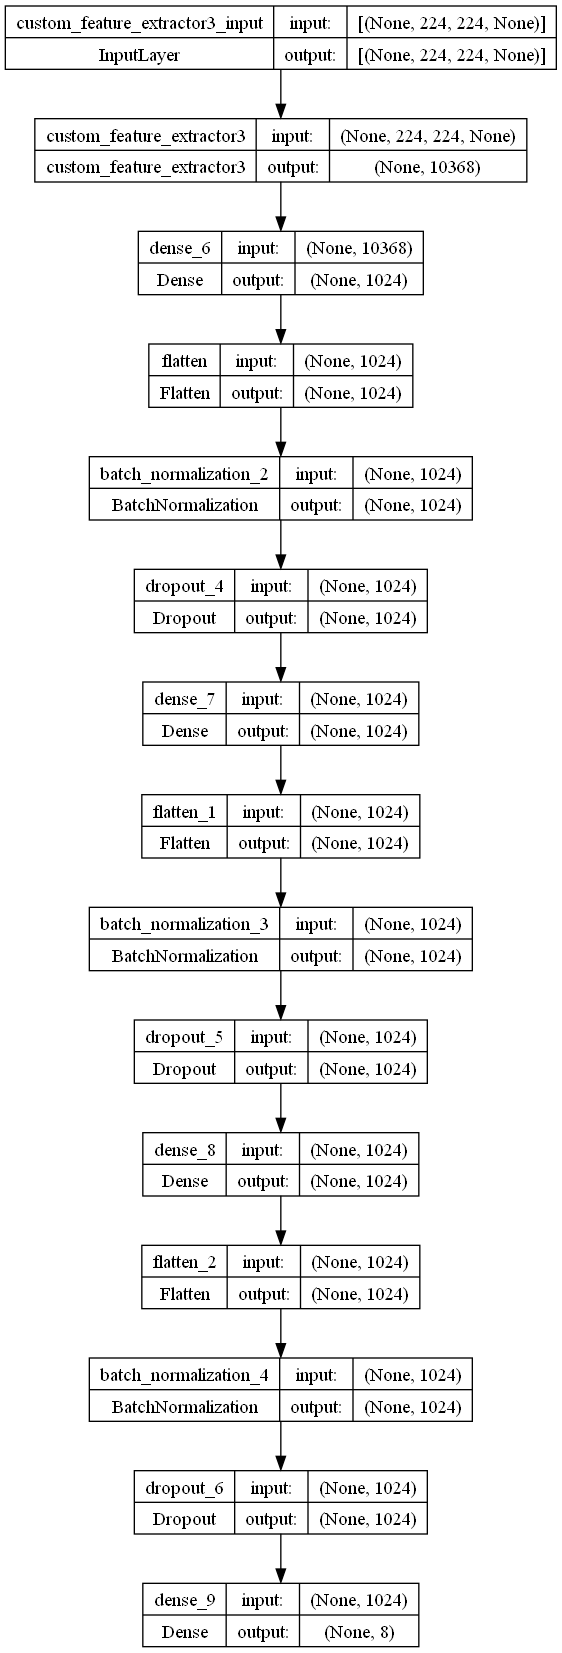

In [65]:
tf.keras.utils.plot_model(age_model_3, show_shapes=True, show_layer_names=True, to_file='final_age_model.png')

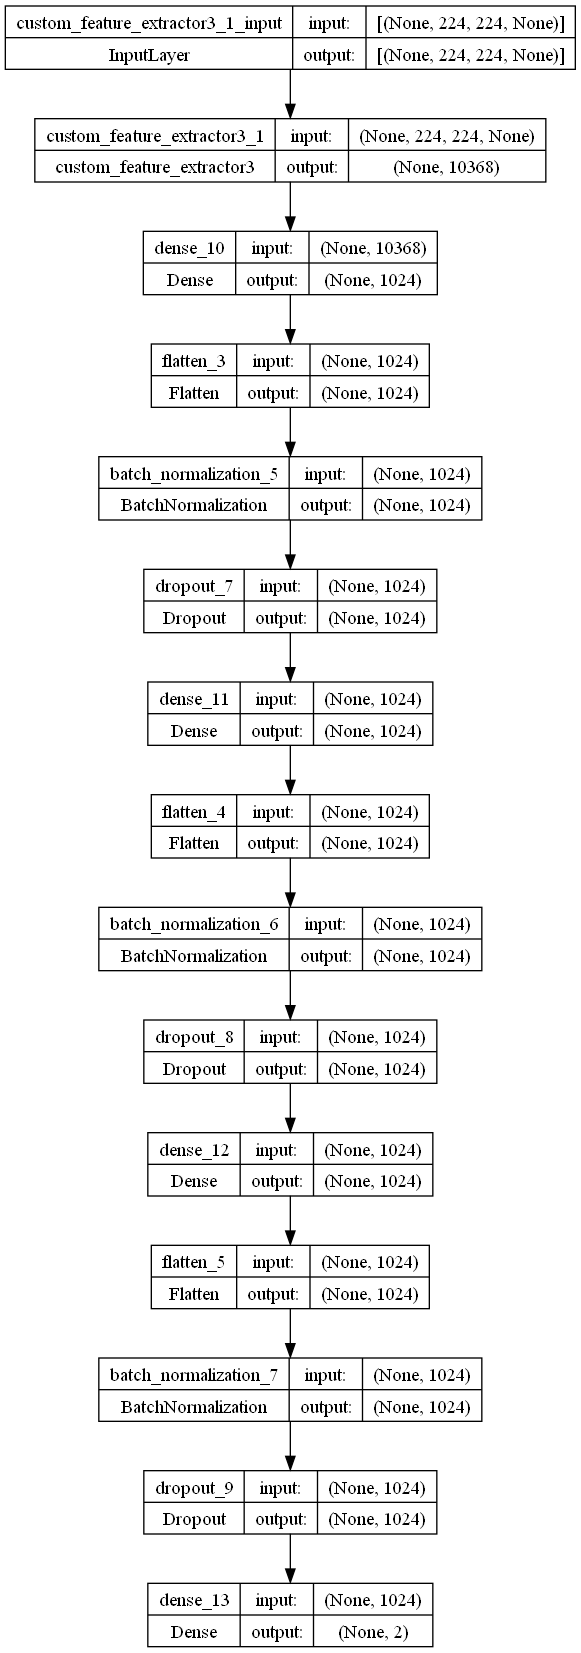

In [66]:
tf.keras.utils.plot_model(gender_model_3, show_shapes=True, show_layer_names=True, to_file='final_gender_model.png')

In [32]:
age_model_3_results = age_model_3.fit(train_age_dataset, validation_data=val_age_dataset ,epochs=10)
gender_model_3_results = gender_model_3.fit(train_gender_dataset, validation_data=val_gender_dataset ,epochs=10)

age_model_3.save("checkpoints/age_model_3.h5")
gender_model_3.save("checkpoints/gender_model_3.h5")

Epoch 1/10
811/811 [==============================] - 210s 257ms/step - loss: 2.1871 - accuracy: 0.3060 - val_loss: 1.6767 - val_accuracy: 0.3813
Epoch 2/10
811/811 [==============================] - 204s 251ms/step - loss: 1.5947 - accuracy: 0.4173 - val_loss: 1.3340 - val_accuracy: 0.4852
Epoch 3/10
811/811 [==============================] - 204s 252ms/step - loss: 1.4503 - accuracy: 0.4545 - val_loss: 1.4423 - val_accuracy: 0.4470
Epoch 4/10
811/811 [==============================] - 203s 250ms/step - loss: 1.3563 - accuracy: 0.4808 - val_loss: 1.3260 - val_accuracy: 0.4976
Epoch 5/10
811/811 [==============================] - 203s 250ms/step - loss: 1.3069 - accuracy: 0.4964 - val_loss: 1.2760 - val_accuracy: 0.5131
Epoch 6/10
811/811 [==============================] - 206s 255ms/step - loss: 1.2294 - accuracy: 0.5272 - val_loss: 1.2768 - val_accuracy: 0.5193
Epoch 7/10
811/811 [==============================] - 202s 249ms/step - loss: 1.1570 - accuracy: 0.5533 - val_loss: 1.2337 -

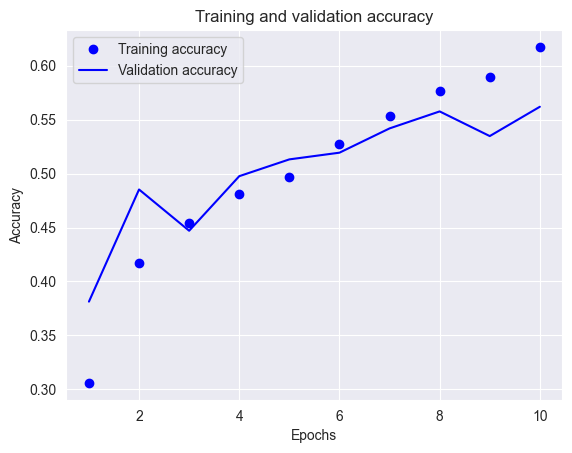

In [33]:
plot_accuracy(age_model_3_results.history['accuracy'], age_model_3_results.history['val_accuracy'])

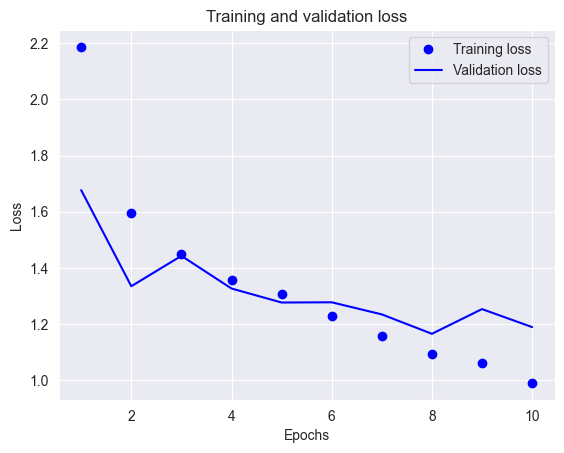

In [34]:
plot_loss(age_model_3_results.history['loss'], age_model_3_results.history['val_loss'])

129/129 [==============================] - 8s 60ms/step
Accuracy: 55.05344995140914
Precision: 0.5558393901591699
Recall: 0.5505344995140914
F1 Score: 0.5313575500473136
Confusion Matrix:


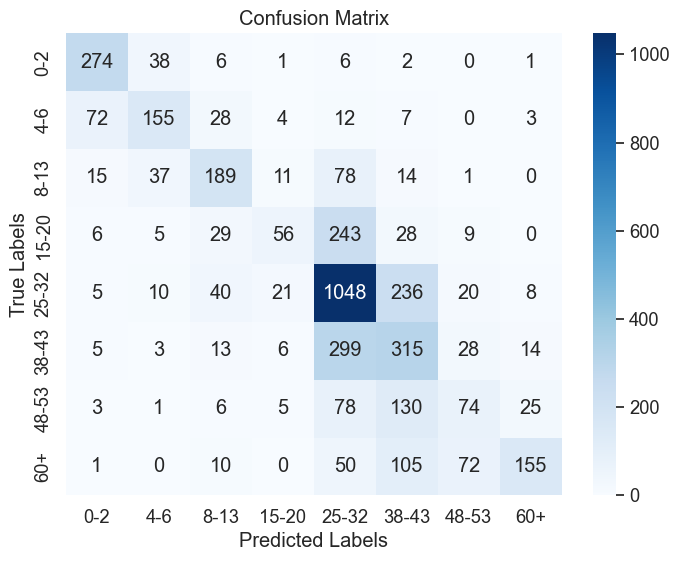

In [100]:
#age results
age_model_3.load_weights("checkpoints/age_model_3.h5")
a_pred = age_model_3.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

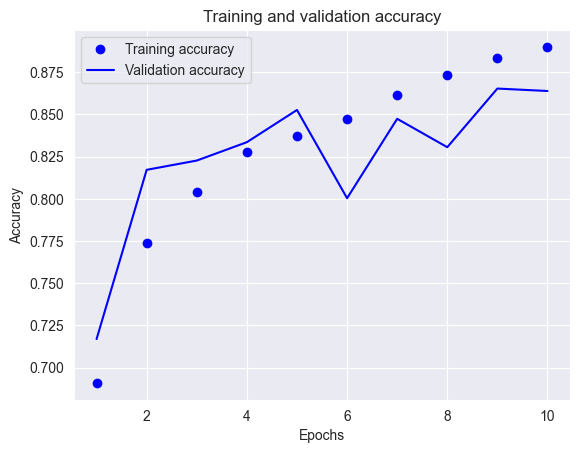

In [36]:
plot_accuracy(gender_model_3_results.history['accuracy'], gender_model_3_results.history['val_accuracy'])

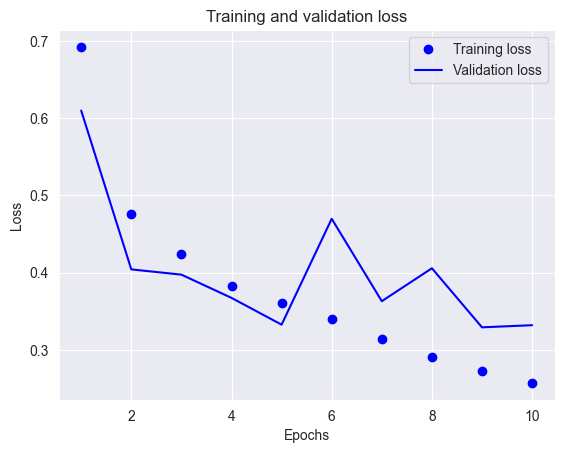

In [37]:
plot_loss(gender_model_3_results.history['loss'], gender_model_3_results.history['val_loss'])

129/129 [==============================] - 7s 57ms/step
Accuracy: 88.09523809523809
Precision: 0.8868471953578336
Recall: 0.877511961722488
F1 Score: 0.8821548821548821
Confusion Matrix:


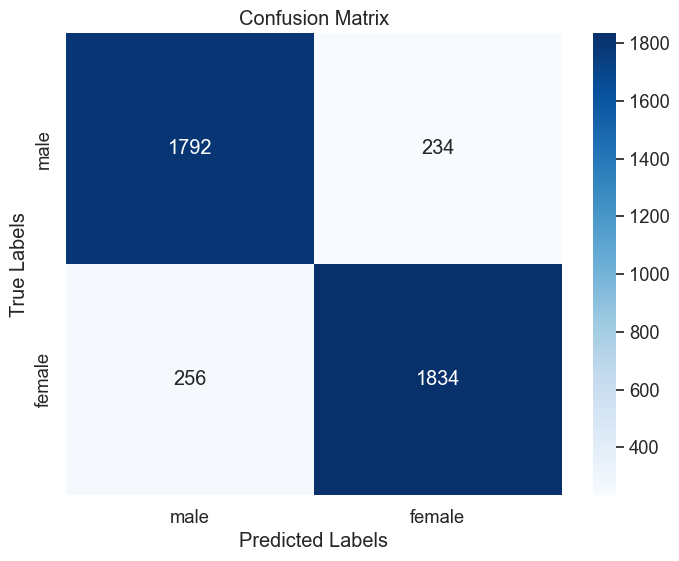

In [82]:
#gender results
gender_model_3.save("checkpoints/gender_model_3.h5")
g_pred = gender_model_3.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

As we can see from the results, my current model has performed better than the previous versions and I want to try if fine tuning it is able to increase the accuracy

In [41]:
# load the pretrained weights
age_model_3.load_weights("checkpoints/age_model_3.h5")
gender_model_3.load_weights("checkpoints/gender_model_3.h5")

age_model_3.layers[0].set_trainable(False)
gender_model_3.layers[0].set_trainable(False)

for layer in age_model_3.layers[1:]:
    layer.trainable = True

for layer in gender_model_3.layers[1:]:
    layer.trainable = True

# fine-tuning of model

age_3_fine_results = age_model_3.fit(train_age_dataset, validation_data=val_age_dataset, epochs=10)
gender_3_fine_results = gender_model_3.fit(train_gender_dataset, validation_data=val_gender_dataset, epochs=10)

age_model_3.save("checkpoints/age_model_3_fine.h5")
gender_model_3.save("checkpoints/gender_model_3_fine.h5")

Epoch 1/10
811/811 [==============================] - 205s 253ms/step - loss: 0.9444 - accuracy: 0.6334 - val_loss: 1.1626 - val_accuracy: 0.5715
Epoch 2/10
811/811 [==============================] - 199s 245ms/step - loss: 0.9148 - accuracy: 0.6443 - val_loss: 1.1725 - val_accuracy: 0.5742
Epoch 3/10
811/811 [==============================] - 200s 246ms/step - loss: 0.8344 - accuracy: 0.6771 - val_loss: 1.2177 - val_accuracy: 0.5597
Epoch 4/10
811/811 [==============================] - 199s 245ms/step - loss: 0.8112 - accuracy: 0.6880 - val_loss: 1.2575 - val_accuracy: 0.5516
Epoch 5/10
811/811 [==============================] - 201s 248ms/step - loss: 0.7548 - accuracy: 0.7081 - val_loss: 1.1840 - val_accuracy: 0.5861
Epoch 6/10
811/811 [==============================] - 200s 247ms/step - loss: 0.7179 - accuracy: 0.7216 - val_loss: 1.1683 - val_accuracy: 0.5953
Epoch 7/10
811/811 [==============================] - 201s 248ms/step - loss: 0.6751 - accuracy: 0.7427 - val_loss: 1.2864 -

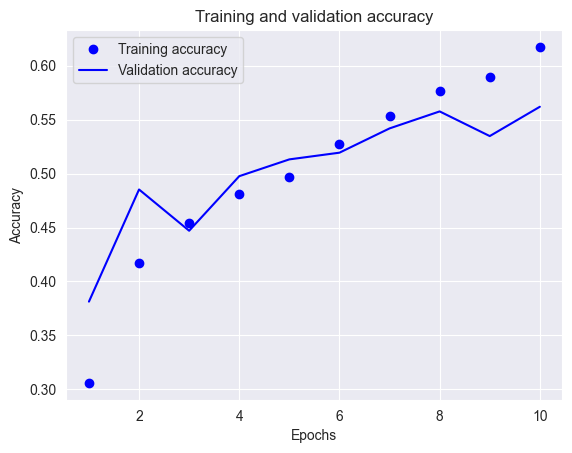

In [42]:
plot_accuracy(age_model_3_results.history['accuracy'], age_model_3_results.history['val_accuracy'])

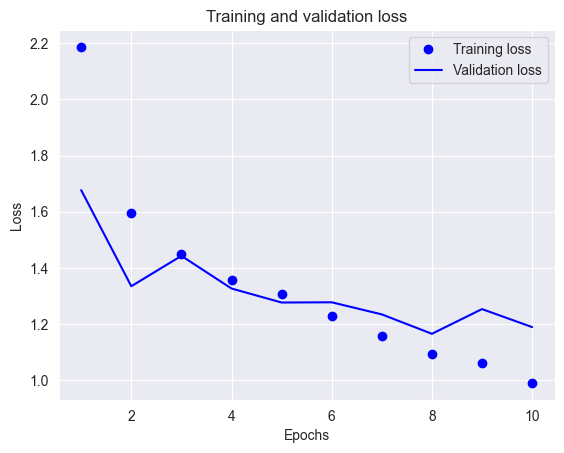

In [43]:
plot_loss(age_model_3_results.history['loss'], age_model_3_results.history['val_loss'])

129/129 [==============================] - 7s 56ms/step
Accuracy: 58.86783284742469
Precision: 0.5812987771524717
Recall: 0.5886783284742468
F1 Score: 0.57398647336891
Confusion Matrix:


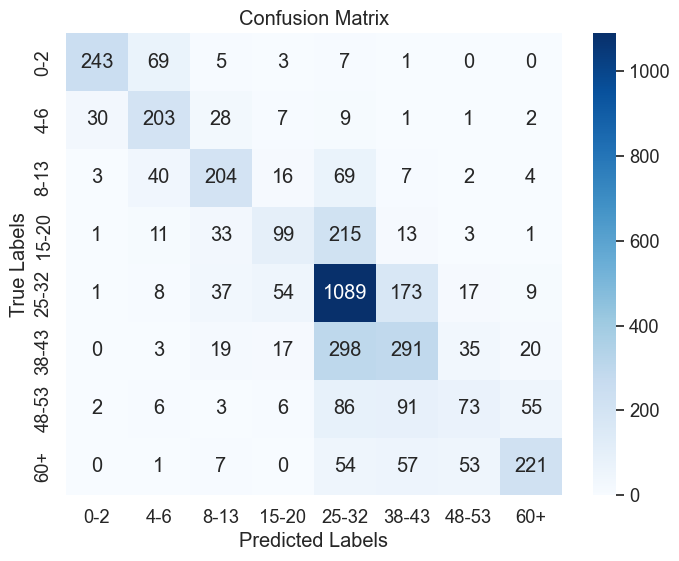

In [96]:
#age results
age_model_3.load_weights("checkpoints/age_model_3_fine.h5")
a_pred = age_model_3.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

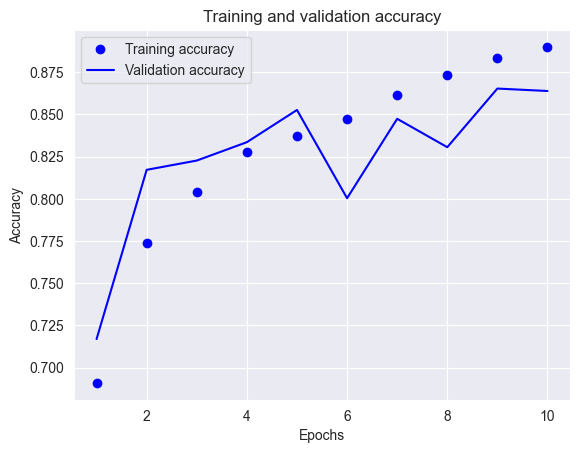

In [45]:
plot_accuracy(gender_model_3_results.history['accuracy'], gender_model_3_results.history['val_accuracy'])

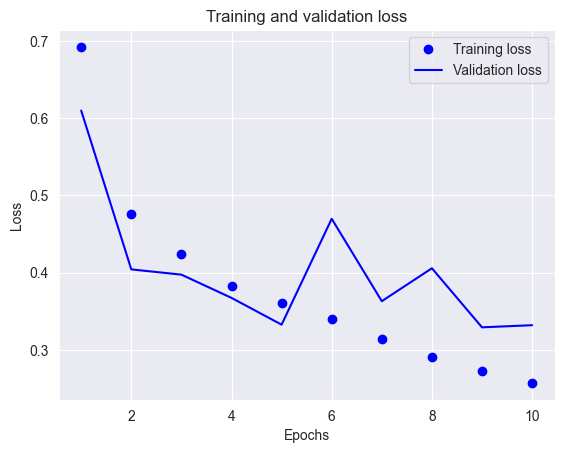

In [46]:
plot_loss(gender_model_3_results.history['loss'], gender_model_3_results.history['val_loss'])

129/129 [==============================] - 8s 58ms/step
Accuracy: 88.09523809523809
Precision: 0.8868471953578336
Recall: 0.877511961722488
F1 Score: 0.8821548821548821
Confusion Matrix:


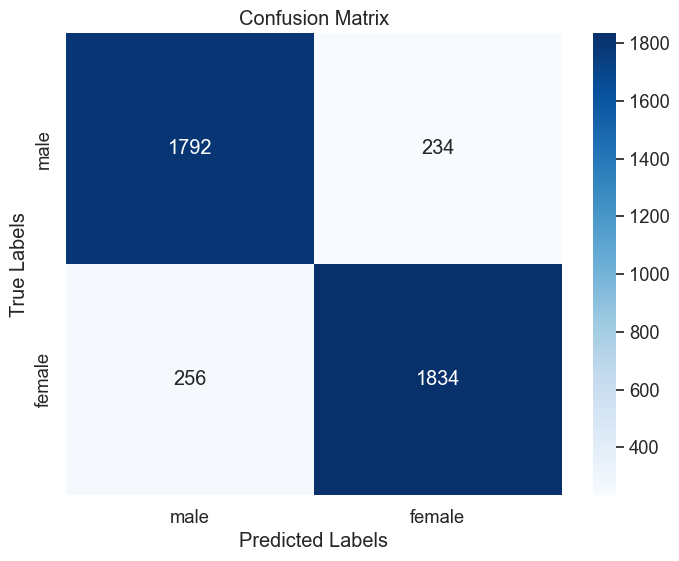

In [83]:
#gender results
gender_model_3.save("checkpoints/gender_model_3_fine.h5")
g_pred = gender_model_3.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)

As this seems to be the most successful version of my model so far, I decided to compare the resnet50 and vgg16 version

In [51]:
resnet_model_2 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

with tf.device('/GPU:0'):
    age_resnet50_model_2 = tf.keras.Sequential([
        resnet_model_2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.55),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.55),
        tf.keras.layers.Dense(8, activation='softmax')
    ])


    gender_resnet50_model_2 = tf.keras.Sequential([
        resnet_model_2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

input_shape = (None, 224, 224, 3)
age_resnet50_model_2.build(input_shape)
gender_resnet50_model_2.build(input_shape)
age_resnet50_model_2.summary()
gender_resnet50_model_2.summary()
age_resnet50_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gender_resnet50_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_20 (Dense)            (None, 1024)              2098176   
                                                                 
 flatten_6 (Flatten)         (None, 1024)              0         
                                                                 
 batch_normalization_8 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 1024)             

In [52]:
age_resnet50_results2 = age_resnet50_model_2.fit(train_age_dataset, validation_data=val_age_dataset ,epochs=10)
gender_resnet50_results2 = gender_resnet50_model_2.fit(train_gender_dataset, validation_data=val_gender_dataset ,epochs=10)

age_resnet50_model_2.save('checkpoints/age_resnet50_model_2.h5')
gender_resnet50_model_2.save('checkpoints/gender_resnet50_model_2.h5')

Epoch 1/10
811/811 [==============================] - 2097s 3s/step - loss: 2.4308 - accuracy: 0.2516 - val_loss: 2.0139 - val_accuracy: 0.3351
Epoch 2/10
811/811 [==============================] - 2075s 3s/step - loss: 2.1496 - accuracy: 0.3003 - val_loss: 2.4913 - val_accuracy: 0.2662
Epoch 3/10
811/811 [==============================] - 2064s 3s/step - loss: 2.0803 - accuracy: 0.3045 - val_loss: 6.3296 - val_accuracy: 0.2303
Epoch 4/10
811/811 [==============================] - 2059s 3s/step - loss: 2.0112 - accuracy: 0.3133 - val_loss: 4.1479 - val_accuracy: 0.2374
Epoch 5/10
811/811 [==============================] - 2056s 3s/step - loss: 1.9376 - accuracy: 0.3377 - val_loss: 28.3354 - val_accuracy: 0.0840
Epoch 6/10
811/811 [==============================] - 2071s 3s/step - loss: 1.8688 - accuracy: 0.3542 - val_loss: 1.9009 - val_accuracy: 0.3513
Epoch 7/10
811/811 [==============================] - 2054s 3s/step - loss: 1.8013 - accuracy: 0.3677 - val_loss: 1.7782 - val_accuracy

129/129 [==============================] - 79s 615ms/step
Accuracy: 30.174927113702626
Precision: 0.217324007500522
Recall: 0.30174927113702626
F1 Score: 0.20782646306535396
Confusion Matrix:


C:\Users\keane\PycharmProjects\pythonProject\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


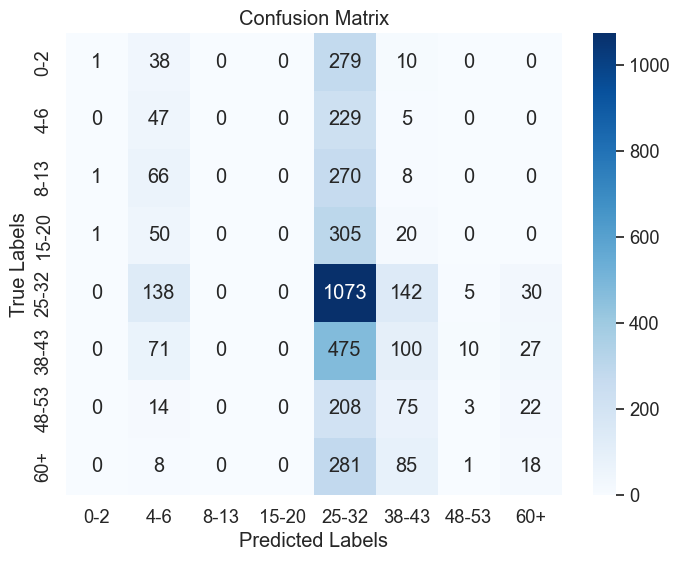

In [101]:
#age results
age_resnet50_model_2.load_weights('checkpoints/age_resnet50_model_2.h5')
a_pred = age_resnet50_model_2.predict(test_ax_dataset)
a_pred  = np.argmax(a_pred, axis=1)
a_accuracy = accuracy_score(test_ay, a_pred) * 100
precision = precision_score(test_ay, a_pred, average='weighted')
recall = recall_score(test_ay, a_pred, average='weighted')
conf_matrix = confusion_matrix(test_ay, a_pred)
f1 = f1_score(test_ay, a_pred, average='weighted')
print("Accuracy:", a_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, age_labels)

129/129 [==============================] - 86s 665ms/step
Accuracy: 86.83187560738581
Precision: 0.9134615384615384
Recall: 0.8181818181818182
F1 Score: 0.8632004038364463
Confusion Matrix:


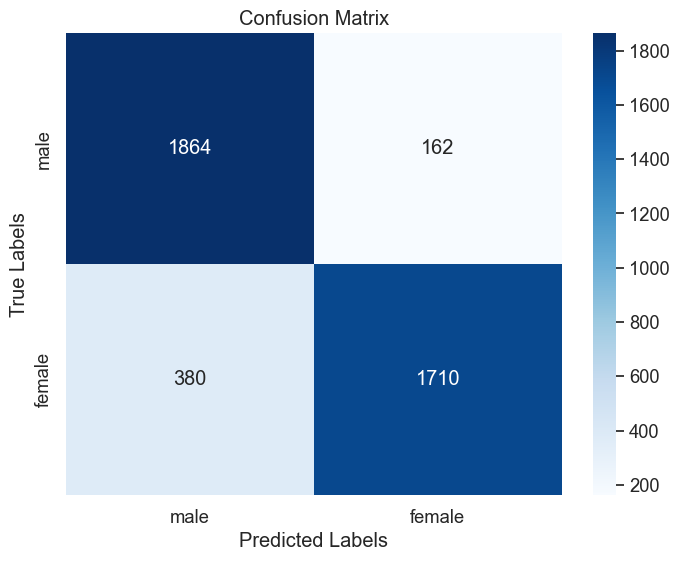

In [84]:
#gender results
gender_resnet50_model_2.load_weights('checkpoints/gender_resnet50_model_2.h5')
g_pred = gender_resnet50_model_2.predict(test_ax_dataset)
g_pred  = np.argmax(g_pred, axis=1)
test_gy = np.asarray(test_gy).astype(np.float32)
g_accuracy = accuracy_score(test_gy, g_pred) * 100
precision = precision_score(test_gy, g_pred)
recall = recall_score(test_gy, g_pred)
conf_matrix = confusion_matrix(test_gy, g_pred)
f1 = f1_score(test_gy, g_pred)
print("Accuracy:", g_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
plot_confusion_matrix(conf_matrix, gender_labels)